In [6]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import pickle
from utils import load_mnist
import os
import time

In [7]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [8]:
class StudentModel:
    def __init__(self, 
                 model_type,
                 num_steps=500, 
                 batch_size=128, 
                 display_step=100, 
                 n_hidden_1=256,
                 n_hidden_2=256,
                 num_input=784, 
                 num_classes=10,
                 dropoutprob=0.75,
                 checkpoint_dir="checkpoint",
                 checkpoint_file="smallmodel",
                 temperature=1.0,
                 log_dir="logs", 
                 learning_rate=0.001):
        
        self.learning_rate = learning_rate
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.display_step = display_step
        self.n_hidden_1 = n_hidden_1  # 1st layer number of neurons
        self.n_hidden_2 = n_hidden_2  # 2nd layer number of neurons
        self.num_input = num_input  # MNIST data input (img shape: 28*28)
        self.num_classes = num_classes
        self.temperature = temperature
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = checkpoint_file
        self.checkpoint_path = os.path.join(self.checkpoint_dir, self.checkpoint_file)
        self.max_checkpoint_path = os.path.join(self.checkpoint_dir, self.checkpoint_file + "max")
        self.log_dir = os.path.join(log_dir, self.checkpoint_file)
        self.model_type = model_type

        self.weights = {
            'h1': tf.Variable(tf.random_normal([self.num_input, self.n_hidden_1]),
                              name="%s_%s" % (self.model_type, "h1")),
            'h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_hidden_2]),
                              name="%s_%s" % (self.model_type, "h2")),
            'out': tf.Variable(tf.random_normal([self.n_hidden_2, self.num_classes]),
                               name="%s_%s" % (self.model_type, "out")),
            'linear': tf.Variable(tf.random_normal([self.num_input, self.num_classes]),
                                  name="%s_%s" % (self.model_type, "linear"))
        }
        self.biases = {
            'b1': tf.Variable(tf.random_normal([self.n_hidden_1]), name="%s_%s" % (self.model_type, "b1")),
            'b2': tf.Variable(tf.random_normal([self.n_hidden_2]), name="%s_%s" % (self.model_type, "b2")),
            'out': tf.Variable(tf.random_normal([self.num_classes]), name="%s_%s" % (self.model_type, "out")),
            'linear': tf.Variable(tf.random_normal([self.num_classes]), name="%s_%s" % (self.model_type, "linear"))
        }

        self.build_model()

        self.saver = tf.train.Saver()

    # Create model
    def build_model(self):
        self.X = tf.placeholder(tf.float32, [None, self.num_input], name="%s_%s" % (self.model_type, "xinput"))
        self.Y = tf.placeholder(tf.float32, [None, self.num_classes], name="%s_%s" % (self.model_type, "yinput"))

        self.flag = tf.placeholder(tf.bool, None, name="%s_%s" % (self.model_type, "flag"))
        self.soft_Y = tf.placeholder(tf.float32, [None, self.num_classes], name="%s_%s" % (self.model_type, "softy"))
        self.softmax_temperature = tf.placeholder(tf.float32, name="%s_%s" % (self.model_type, "softmaxtemperature"))

        with tf.name_scope("%sfclayer" % (self.model_type)), tf.variable_scope("%sfclayer" % (self.model_type)):
            # Hidden fully connected layer with 256 neurons
            layer_1 = tf.add(tf.matmul(self.X, self.weights['h1']), self.biases['b1'])
            # # Hidden fully connected layer with 256 neurons
            layer_2 = tf.add(tf.matmul(layer_1, self.weights['h2']), self.biases['b2'])
            # # Output fully connected layer with a neuron for each class
            logits = (tf.matmul(layer_2, self.weights['out']) + self.biases['out'])
            # logits = tf.add(tf.matmul(self.X, self.weights['linear']), self.biases['linear'])

        with tf.name_scope("%sprediction" % (self.model_type)), tf.variable_scope("%sprediction" % (self.model_type)):
            self.prediction = tf.nn.softmax(logits)

            self.correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(self.Y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        with tf.name_scope("%soptimization" % (self.model_type)), tf.variable_scope(
                        "%soptimization" % (self.model_type)):
            # Define loss and optimizer
            self.loss_op_standard = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=self.Y))

            self.total_loss = self.loss_op_standard

            self.loss_op_soft = tf.cond(self.flag,
                                        true_fn=lambda: tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                                            logits=logits / self.softmax_temperature, labels=self.soft_Y)),
                                        false_fn=lambda: 0.0)

            self.total_loss += tf.square(self.softmax_temperature) * self.loss_op_soft

            # optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            # optimizer = tf.train.GradientDescentOptimizer(0.05)
            # self.global_step = tf.Variable(0, trainable=False)
            # self.increment_global_step_op = tf.assign(self.global_step, self.global_step+1)
            # self.ad_learning_rate = tf.train.exponential_decay(self.learning_rate, self.global_step,
            #                                1000, 0.96, staircase=True)
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            # self.train_op = optimizer.minimize(self.total_loss, global_step=self.global_step)
            self.train_op = optimizer.minimize(self.total_loss)

        with tf.name_scope("%ssummarization" % (self.model_type)), tf.variable_scope(
                        "%ssummarization" % (self.model_type)):
            tf.summary.scalar("loss_op_standard", self.loss_op_standard)
            tf.summary.scalar("total_loss", self.total_loss)
            # Create a summary to monitor accuracy tensor
            tf.summary.scalar("accuracy", self.accuracy)

            for var in tf.trainable_variables():
                tf.summary.histogram(var.name, var)

            # Merge all summaries into a single op

            # If using TF 1.6 or above, simply use the following merge_all function
            # which supports scoping
            self.merged_summary_op = tf.summary.merge_all(scope=self.model_type)

    def start_session(self):
        self.sess = tf.Session()

    def close_session(self):
        self.sess.close()

    def train(self, data, logits_distill=None):
        teacher_flag = False
        if logits_distill is not None:
            teacher_flag = True
        
        X_train = data['X_train']
        y_train = data['y_train']
        X_val = data['X_val']
        y_val = data['y_val']
        
        # Initialize the variables (i.e. assign their default value)
        self.sess.run(tf.global_variables_initializer())
        train_summary_writer = tf.summary.FileWriter(self.log_dir, graph=self.sess.graph)

        max_accuracy = 0

        print("Starting Training")

        def dev_step():
            validation_x = X_val
            validation_y = y_val
        
            loss, acc = self.sess.run([self.loss_op_standard, self.accuracy], feed_dict={self.X: validation_x,
                                                                                         self.Y: validation_y,
                                                                                         # self.soft_Y: validation_y,
                                                                                         self.flag: False,
                                                                                         self.softmax_temperature: 1.0})

            if acc > max_accuracy:
                save_path = self.saver.save(self.sess, self.checkpoint_path)
                print("Model Checkpointed to %s " % (save_path))

            print("Step " + str(step) + ", Validation Loss= " + "{:.4f}".format(
                loss) + ", Validation Accuracy= " + "{:.3f}".format(acc))
        
        for step in range(1, self.num_steps + 1):
            batch_x, batch_y, batch_logits = self.get_batch(X_train, y_train, logits_distill)
            soft_targets = batch_y
            if teacher_flag:
                # soft_targets = self.sess.run(tf.nn.softmax(batch_logits / self.temperature))
                soft_targets = batch_logits
                
            # self.sess.run(self.train_op,
            _, summary = self.sess.run([self.train_op, self.merged_summary_op],
                                       feed_dict={self.X: batch_x,
                                                  self.Y: batch_y,
                                                  self.soft_Y: soft_targets,
                                                  self.flag: teacher_flag,
                                                  self.softmax_temperature: self.temperature}
                                       )
            train_summary_writer.add_summary(summary, step)
            
            if (step % self.display_step) == 0 or step == 1:
                dev_step()
        else:
            # Final Evaluation and checkpointing before training ends
            dev_step()
        
        train_summary_writer.close()

        print("Optimization Finished!")

    def get_batch(self, X_train, y_train, logits_distill=None):
        num_train = X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = X_train[batch_mask]
        y_batch = y_train[batch_mask]
        if logits_distill is not None:
            logit_batch = logits_distill[batch_mask]
        else:
            logit_batch = None
        return X_batch, y_batch, logit_batch
    
    def predict(self, data_X, temperature=1.0):
        return self.sess.run(self.prediction,
                             feed_dict={self.X: data_X, self.flag: False, self.softmax_temperature: temperature})

    def run_inference_test(self, data):   
        X_test = data['X_test']
        y_test = data['y_test']
        batch_size = self.batch_size
        batch_num = int(len(X_test) / batch_size)
        test_accuracy = 0

        for i in range(batch_num):
            batch_x = X_test[(batch_size * i):batch_size * (i + 1)]
            batch_y = y_test[(batch_size * i):batch_size * (i + 1)]
            test_accuracy += self.sess.run(self.accuracy, feed_dict={self.X: batch_x,
                                                                     self.Y: batch_y,
                                                                     self.flag: False,
                                                                     self.softmax_temperature: 1.0
                                                                    })
        # test_images, test_labels = dataset.get_test_data()
        # print("Testing Accuracy:", self.sess.run(self.accuracy, feed_dict={self.X: test_images,
                                                                           # self.Y: test_labels,
                                                                           # # self.soft_Y: test_labels,
                                                                           # self.flag: False,
                                                                           # self.softmax_temperature: 1.0
                                                                           # }))
        test_accuracy /= batch_num
        print("Testing Accuracy: %g"%test_accuracy)
        
    def run_inference_training(self, data, batch_size):   
        X_test = data['X_train']
        y_test = data['y_train']
        batch_num = int(len(X_test) / batch_size)
        test_accuracy = 0

        for i in range(batch_num):
            batch_x = X_test[(batch_size * i):batch_size * (i + 1)]
            batch_y = y_test[(batch_size * i):batch_size * (i + 1)]
            test_accuracy += self.sess.run(self.accuracy, feed_dict={self.X: batch_x,
                                                                     self.Y: batch_y,
                                                                     self.flag: False,
                                                                     self.softmax_temperature: 1.0
                                                                    })
        # test_images, test_labels = dataset.get_test_data()
        # print("Testing Accuracy:", self.sess.run(self.accuracy, feed_dict={self.X: test_images,
                                                                           # self.Y: test_labels,
                                                                           # # self.soft_Y: test_labels,
                                                                           # self.flag: False,
                                                                           # self.softmax_temperature: 1.0
                                                                           # }))
        test_accuracy /= batch_num
        return test_accuracy
        
    def run_inference_validation(self, data, batch_size):   
        X_test = data['X_val']
        y_test = data['y_val']
        batch_num = int(len(X_test) / batch_size)
        test_accuracy = 0

        for i in range(batch_num):
            batch_x = X_test[(batch_size * i):batch_size * (i + 1)]
            batch_y = y_test[(batch_size * i):batch_size * (i + 1)]
            test_accuracy += self.sess.run(self.accuracy, feed_dict={self.X: batch_x,
                                                                     self.Y: batch_y,
                                                                     self.flag: False,
                                                                     self.softmax_temperature: 1.0
                                                                    })
        # test_images, test_labels = dataset.get_test_data()
        # print("Testing Accuracy:", self.sess.run(self.accuracy, feed_dict={self.X: test_images,
                                                                           # self.Y: test_labels,
                                                                           # # self.soft_Y: test_labels,
                                                                           # self.flag: False,
                                                                           # self.softmax_temperature: 1.0
                                                                           # }))
        test_accuracy /= batch_num
        return test_accuracy
        
    def run_inference_ex(self, dataset_ex):
        test_images, test_labels = dataset_ex.get_test_data_ex()
        print("Testing Accuracy:", self.sess.run(self.accuracy, feed_dict={self.X: test_images,
                                                                           self.Y: test_labels,
                                                                           # self.soft_Y: test_labels,
                                                                           self.flag: False,
                                                                           self.softmax_temperature: 1.0
                                                                           }))

    def load_model_from_file(self, load_path):
        ckpt = tf.train.get_checkpoint_state(load_path)
        if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
            print("Reading model parameters from %s" % ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, ckpt.model_checkpoint_path)
        else:
            print("Created model with fresh parameters.")
            self.sess.run(tf.global_variables_initializer())

In [9]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## ShuffleNet

In [5]:
teacher_train_logits = np.load(
    '../../data/shuffleNet/new_teacher_train_logits.npz')['arr_0']
teacher_val_logits = np.load(
    '../../data/shuffleNet/new_teacher_val_logits.npz')['arr_0']
x_val = np.load('../../data/shuffleNet/x_val.npz')['arr_0']
x_train = np.load('../../data/shuffleNet/new_x_train.npz')['arr_0']
y_train = np.load('../../data/shuffleNet/new_y_train.npz')['arr_0']
y_val = np.load('../../data/shuffleNet/y_val.npz')['arr_0']

In [69]:
teacher_train_logits.shape

(98179, 200)

In [70]:
#one hot representation
y_train = to_categorical(y_train)
y_val= to_categorical(y_val)

In [71]:
print(x_train.shape)
print(y_train.shape)

(98179, 56, 56, 3)
(98179, 200)


In [72]:
# Prepare data to train with small model
data = {'X_train': x_train.reshape(len(x_train), 9408).copy(), 'y_train': y_train,
        'X_val': x_val.reshape(len(x_val), 9408).copy(), 'y_val': y_val,
       }

In [52]:
temperature = 1
checkpoint_dir="new_studentcpt_shuffle_t{0}".format(temperature)
log_dir=checkpoint_dir + "\logs"

In [53]:
student_model = StudentModel(num_steps=2000, 
                                 batch_size=128,
                                 learning_rate=0.01,
                                 temperature=temperature,
                                 num_input=9408, 
                                 num_classes=200,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

In [12]:
# To speedup the calculations.
session = tf.Session()
soft_targets = session.run(tf.nn.softmax(teacher_train_logits / temperature))

In [54]:
student_model.start_session()

In [55]:
student_model.train(data)

Starting Training
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 1, Validation Loss= 53367.6211, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 100, Validation Loss= 13798.5693, Validation Accuracy= 0.008
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 200, Validation Loss= 11903.0166, Validation Accuracy= 0.012
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 300, Validation Loss= 9676.0996, Validation Accuracy= 0.014
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 400, Validation Loss= 9100.8115, Validation Accuracy= 0.017
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 500, Validation Loss= 7749.7207, Validation Accuracy= 0.017
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 600, Validation Loss= 6331.6997, Validation Accuracy= 0.019
Model Checkpointed to new_studentcpt_shuffle_t0\smallmodel 
Step 700, Validation Loss= 5642.6245, Validati

In [56]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference_training(data, 128)

Reading model parameters from new_studentcpt_shuffle_t0\smallmodel


0.03623085071707953

In [57]:
# Close current tf sessions
student_model.close_session()
tf.reset_default_graph()

In [73]:
with open('experiments_shuffle.out', 'w') as file:
    for t in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]:
        file.write('T: {0}\n'.format(t))
        checkpoint_dir="new_studentcpt_shuffle_t{0}".format(t)
        log_dir=checkpoint_dir + "\logs"
        student_model = StudentModel(num_steps=2000, 
                                 batch_size=128,
                                 learning_rate=0.01,
                                 temperature=t,
                                 num_input=9408, 
                                 num_classes=200,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");
        student_model.start_session()
        
        #Compute logits
        # To speedup the calculations.
        print("Pre-computing logits\n")
        session = tf.Session()
        soft_targets = session.run(tf.nn.softmax(teacher_train_logits / t))
        
        # Training
        start_time = time.time()
        student_model.train(data, soft_targets)
        duration = time.time() - start_time
    
        train_acc = student_model.run_inference_training(data, 128)
        val_acc = student_model.run_inference_validation(data, 128)
        exec_time = duration
        
        # Close current tf sessions
        student_model.close_session()
        tf.reset_default_graph()
    
        file.write('Results: Training Accuracy: {0}, Validation Accuracy: {1}, Execution time: {2}\n'.format(
            train_acc, val_acc, exec_time))

Pre-computing logits

Starting Training
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 1, Validation Loss= 44538.9297, Validation Accuracy= 0.004
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 100, Validation Loss= 13111.8350, Validation Accuracy= 0.014
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 200, Validation Loss= 11300.2900, Validation Accuracy= 0.015
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 300, Validation Loss= 10288.0947, Validation Accuracy= 0.014
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 400, Validation Loss= 7477.6816, Validation Accuracy= 0.016
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 500, Validation Loss= 7039.8618, Validation Accuracy= 0.016
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 600, Validation Loss= 6383.9590, Validation Accuracy= 0.016
Model Checkpointed to new_studentcpt_shuffle_t1\smallmodel 
Step 700, Validation Lo

Model Checkpointed to new_studentcpt_shuffle_t3\smallmodel 
Step 2000, Validation Loss= 436.5392, Validation Accuracy= 0.008
Optimization Finished!
Pre-computing logits

Starting Training
Model Checkpointed to new_studentcpt_shuffle_t4\smallmodel 
Step 1, Validation Loss= 39875.2695, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t4\smallmodel 
Step 100, Validation Loss= 12037.2773, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t4\smallmodel 
Step 200, Validation Loss= 10828.8027, Validation Accuracy= 0.006
Model Checkpointed to new_studentcpt_shuffle_t4\smallmodel 
Step 300, Validation Loss= 10582.3174, Validation Accuracy= 0.008
Model Checkpointed to new_studentcpt_shuffle_t4\smallmodel 
Step 400, Validation Loss= 9097.5020, Validation Accuracy= 0.007
Model Checkpointed to new_studentcpt_shuffle_t4\smallmodel 
Step 500, Validation Loss= 6634.5117, Validation Accuracy= 0.009
Model Checkpointed to new_studentcpt_shuffle_t4\smallmodel 


Model Checkpointed to new_studentcpt_shuffle_t6\smallmodel 
Step 1900, Validation Loss= 794.2504, Validation Accuracy= 0.007
Model Checkpointed to new_studentcpt_shuffle_t6\smallmodel 
Step 2000, Validation Loss= 667.1056, Validation Accuracy= 0.007
Model Checkpointed to new_studentcpt_shuffle_t6\smallmodel 
Step 2000, Validation Loss= 667.1056, Validation Accuracy= 0.007
Optimization Finished!
Pre-computing logits

Starting Training
Model Checkpointed to new_studentcpt_shuffle_t7\smallmodel 
Step 1, Validation Loss= 42463.5586, Validation Accuracy= 0.004
Model Checkpointed to new_studentcpt_shuffle_t7\smallmodel 
Step 100, Validation Loss= 11712.6865, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t7\smallmodel 
Step 200, Validation Loss= 11518.0391, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t7\smallmodel 
Step 300, Validation Loss= 11522.6377, Validation Accuracy= 0.006
Model Checkpointed to new_studentcpt_shuffle_t7\smallmodel 


Model Checkpointed to new_studentcpt_shuffle_t9\smallmodel 
Step 1700, Validation Loss= 701.8945, Validation Accuracy= 0.006
Model Checkpointed to new_studentcpt_shuffle_t9\smallmodel 
Step 1800, Validation Loss= 578.1956, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t9\smallmodel 
Step 1900, Validation Loss= 476.3673, Validation Accuracy= 0.006
Model Checkpointed to new_studentcpt_shuffle_t9\smallmodel 
Step 2000, Validation Loss= 395.8695, Validation Accuracy= 0.006
Model Checkpointed to new_studentcpt_shuffle_t9\smallmodel 
Step 2000, Validation Loss= 395.8695, Validation Accuracy= 0.006
Optimization Finished!
Pre-computing logits

Starting Training
Model Checkpointed to new_studentcpt_shuffle_t10\smallmodel 
Step 1, Validation Loss= 38523.9453, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t10\smallmodel 
Step 100, Validation Loss= 11743.4775, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t10\smallmodel 

Model Checkpointed to new_studentcpt_shuffle_t20\smallmodel 
Step 1500, Validation Loss= 4980.8535, Validation Accuracy= 0.006
Model Checkpointed to new_studentcpt_shuffle_t20\smallmodel 
Step 1600, Validation Loss= 4103.4253, Validation Accuracy= 0.005
Model Checkpointed to new_studentcpt_shuffle_t20\smallmodel 
Step 1700, Validation Loss= 3762.3145, Validation Accuracy= 0.007
Model Checkpointed to new_studentcpt_shuffle_t20\smallmodel 
Step 1800, Validation Loss= 3569.8022, Validation Accuracy= 0.007
Model Checkpointed to new_studentcpt_shuffle_t20\smallmodel 
Step 1900, Validation Loss= 3247.5452, Validation Accuracy= 0.006
Model Checkpointed to new_studentcpt_shuffle_t20\smallmodel 
Step 2000, Validation Loss= 3154.4521, Validation Accuracy= 0.007
Model Checkpointed to new_studentcpt_shuffle_t20\smallmodel 
Step 2000, Validation Loss= 3154.4521, Validation Accuracy= 0.007
Optimization Finished!
Pre-computing logits

Starting Training
Model Checkpointed to new_studentcpt_shuffle_t50

## MNIST

In [10]:
logits_train = unpickle('../logits_dir/resnet164_logits_train.txt')

In [11]:
logits_train.shape

(50000, 10)

In [12]:
# Data used in ResNet164
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist()

In [8]:
x_train.shape

(50000, 28, 28, 1)

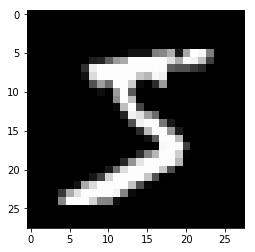

In [22]:
plt.imshow(x_train[0].reshape((28,28)),cmap='gray')

In [9]:
# Prepare data to train with small model
data = {'X_train': x_train.reshape(len(x_train), 784).copy(), 'y_train': y_train,
        'X_val': x_val.reshape(len(x_val), 784).copy(), 'y_val': y_val,
        'X_test': x_test.reshape(len(x_test), 784).copy(), 'y_test': y_test,
       }

In [60]:
checkpoint_dir="new_studentcpt_t1.75"
log_dir=checkpoint_dir + "\logs"
temperature = 1.75

In [61]:
student_model = StudentModel(num_steps=3000, 
                                 batch_size=128,
                                 learning_rate=0.001,
                                 temperature=temperature,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

In [62]:
# To speedup the calculations.
session = tf.Session()
soft_targets = session.run(tf.nn.softmax(logits_train / temperature))

In [63]:
student_model.start_session()
student_model.train(data, soft_targets)

Starting Training
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 1, Validation Loss= 8475.0674, Validation Accuracy= 0.078
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 100, Validation Loss= 812.3453, Validation Accuracy= 0.768
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 200, Validation Loss= 547.8128, Validation Accuracy= 0.828
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 300, Validation Loss= 439.7054, Validation Accuracy= 0.851
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 400, Validation Loss= 385.6259, Validation Accuracy= 0.858
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 500, Validation Loss= 330.9241, Validation Accuracy= 0.868
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 600, Validation Loss= 297.5023, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_t1.75\smallmodel 
Step 700, Validation Loss= 275.9644, Validation Accuracy= 0.875
Model Checkpointed to new_stude

In [64]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference_testing(data)

Reading model parameters from new_studentcpt_t1.75\smallmodel
Testing Accuracy: 0.857691


In [59]:
# Close current tf sessions
student_model.close_session()
tf.reset_default_graph()

In [16]:
big_model_pred = np.argmax(session.run(tf.nn.softmax(logits_train)), 1)

In [17]:
test_pred = np.argmax(y_train,axis=1)

In [19]:
np.sum(big_model_pred == test_pred) / len(y_train)

0.99966

In [10]:
with open('experiments_mnist_full.out', 'w') as file:
    # [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9]
    for n_hidden_1 in [100, 200, 500, 800, 1000]:
        for n_hidden_2 in [100, 200, 500, 800, 1000]:
            file.write('HL1: {0}, HL2: {1}'.format(n_hidden_1, n_hidden_2))
            for t in [1,2,3,4,5,6,7,8,9,10,15,20,50]:
                file.write('T: {0}\n'.format(t))
                checkpoint_dir="new_studentcpt_mnist_hl1{0}_hl2_{1}_t{2}".format(n_hidden_1, n_hidden_2, t)
                log_dir=checkpoint_dir + "\logs"
                student_model = StudentModel(num_steps=3000, 
                                 batch_size=128,
                                 learning_rate=0.001,
                                 temperature=t,
                                 num_input=784, 
                                 num_classes=10,
                                 n_hidden_1=n_hidden_1,
                                 n_hidden_2=n_hidden_2,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");
                student_model.start_session()
        
                # To speedup the calculations.
                session = tf.Session()
                soft_targets = session.run(tf.nn.softmax(logits_train / t))
        
                # Training
                start_time = time.time()
                student_model.train(data, soft_targets)
                duration = time.time() - start_time
    
                train_acc = student_model.run_inference_training(data, 128)
                val_acc = student_model.run_inference_validation(data, 128)
                exec_time = duration
        
                # Close current tf sessions
                student_model.close_session()
                tf.reset_default_graph()
    
                file.write('Results: Training Accuracy: {0}, Validation Accuracy: {1}, Execution time: {2}\n'.format(
                    train_acc, val_acc, exec_time))

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t1\smallmodel 
Step 1, Validation Loss= 4049.6360, Validation Accuracy= 0.066
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t1\smallmodel 
Step 100, Validation Loss= 634.0161, Validation Accuracy= 0.613
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t1\smallmodel 
Step 200, Validation Loss= 361.5135, Validation Accuracy= 0.740
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t1\smallmodel 
Step 300, Validation Loss= 262.0028, Validation Accuracy= 0.796
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t1\smallmodel 
Step 400, Validation Loss= 215.9138, Validation Accuracy= 0.823
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t1\smallmodel 
Step 500, Validation Loss= 189.7149, Validation Accuracy= 0.833
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t1\smallmodel 
Step 600, Validation Loss= 170.9706, Validation Accuracy= 0.841
Model Checkpointed to ne

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t2\smallmodel 
Step 2800, Validation Loss= 53.1382, Validation Accuracy= 0.873
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t2\smallmodel 
Step 2900, Validation Loss= 47.4468, Validation Accuracy= 0.881
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t2\smallmodel 
Step 3000, Validation Loss= 45.9528, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t2\smallmodel 
Step 3000, Validation Loss= 45.9528, Validation Accuracy= 0.884
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t3\smallmodel 
Step 1, Validation Loss= 4506.0137, Validation Accuracy= 0.101
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t3\smallmodel 
Step 100, Validation Loss= 671.1417, Validation Accuracy= 0.592
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t3\smallmodel 
Step 200, Validation Loss= 342.6976, Validation Accuracy= 0.739
M

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t4\smallmodel 
Step 2400, Validation Loss= 38.0736, Validation Accuracy= 0.777
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t4\smallmodel 
Step 2500, Validation Loss= 36.2386, Validation Accuracy= 0.790
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t4\smallmodel 
Step 2600, Validation Loss= 36.0264, Validation Accuracy= 0.780
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t4\smallmodel 
Step 2700, Validation Loss= 32.0533, Validation Accuracy= 0.784
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t4\smallmodel 
Step 2800, Validation Loss= 31.3837, Validation Accuracy= 0.775
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t4\smallmodel 
Step 2900, Validation Loss= 29.7949, Validation Accuracy= 0.774
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t4\smallmodel 
Step 3000, Validation Loss= 27.5532, Validation Accuracy= 0.789
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t6\smallmodel 
Step 2000, Validation Loss= 52.3295, Validation Accuracy= 0.612
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t6\smallmodel 
Step 2100, Validation Loss= 49.1476, Validation Accuracy= 0.606
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t6\smallmodel 
Step 2200, Validation Loss= 44.0751, Validation Accuracy= 0.613
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t6\smallmodel 
Step 2300, Validation Loss= 38.0242, Validation Accuracy= 0.644
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t6\smallmodel 
Step 2400, Validation Loss= 35.8165, Validation Accuracy= 0.633
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t6\smallmodel 
Step 2500, Validation Loss= 32.3976, Validation Accuracy= 0.644
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t6\smallmodel 
Step 2600, Validation Loss= 31.7104, Validation Accuracy= 0.624
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t8\smallmodel 
Step 1600, Validation Loss= 70.9326, Validation Accuracy= 0.465
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t8\smallmodel 
Step 1700, Validation Loss= 59.0663, Validation Accuracy= 0.507
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t8\smallmodel 
Step 1800, Validation Loss= 65.2633, Validation Accuracy= 0.415
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t8\smallmodel 
Step 1900, Validation Loss= 50.8806, Validation Accuracy= 0.484
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t8\smallmodel 
Step 2000, Validation Loss= 46.9058, Validation Accuracy= 0.480
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t8\smallmodel 
Step 2100, Validation Loss= 42.8619, Validation Accuracy= 0.483
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t8\smallmodel 
Step 2200, Validation Loss= 39.9895, Validation Accuracy= 0.485
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t10\smallmodel 
Step 1200, Validation Loss= 100.1258, Validation Accuracy= 0.415
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t10\smallmodel 
Step 1300, Validation Loss= 91.7157, Validation Accuracy= 0.385
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t10\smallmodel 
Step 1400, Validation Loss= 81.1294, Validation Accuracy= 0.383
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t10\smallmodel 
Step 1500, Validation Loss= 70.0396, Validation Accuracy= 0.416
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t10\smallmodel 
Step 1600, Validation Loss= 66.7499, Validation Accuracy= 0.380
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t10\smallmodel 
Step 1700, Validation Loss= 63.9194, Validation Accuracy= 0.343
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t10\smallmodel 
Step 1800, Validation Loss= 51.4458, Validation Accuracy= 0.397
Model Checkpointed to new_student

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t20\smallmodel 
Step 700, Validation Loss= 293.1857, Validation Accuracy= 0.223
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t20\smallmodel 
Step 800, Validation Loss= 256.7580, Validation Accuracy= 0.213
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t20\smallmodel 
Step 900, Validation Loss= 219.2846, Validation Accuracy= 0.214
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t20\smallmodel 
Step 1000, Validation Loss= 184.7112, Validation Accuracy= 0.223
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t20\smallmodel 
Step 1100, Validation Loss= 167.0505, Validation Accuracy= 0.214
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t20\smallmodel 
Step 1200, Validation Loss= 154.1653, Validation Accuracy= 0.193
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_100_t20\smallmodel 
Step 1300, Validation Loss= 118.5794, Validation Accuracy= 0.229
Model Checkpointed to new_stud

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t1\smallmodel 
Step 200, Validation Loss= 371.5122, Validation Accuracy= 0.779
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t1\smallmodel 
Step 300, Validation Loss= 277.9208, Validation Accuracy= 0.818
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t1\smallmodel 
Step 400, Validation Loss= 234.1467, Validation Accuracy= 0.838
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t1\smallmodel 
Step 500, Validation Loss= 208.1581, Validation Accuracy= 0.847
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t1\smallmodel 
Step 600, Validation Loss= 186.7290, Validation Accuracy= 0.858
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t1\smallmodel 
Step 700, Validation Loss= 171.1182, Validation Accuracy= 0.862
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t1\smallmodel 
Step 800, Validation Loss= 159.9555, Validation Accuracy= 0.865
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t2\smallmodel 
Step 3000, Validation Loss= 50.8857, Validation Accuracy= 0.879
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t2\smallmodel 
Step 3000, Validation Loss= 50.8857, Validation Accuracy= 0.879
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t3\smallmodel 
Step 1, Validation Loss= 5041.6631, Validation Accuracy= 0.115
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t3\smallmodel 
Step 100, Validation Loss= 769.3325, Validation Accuracy= 0.641
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t3\smallmodel 
Step 200, Validation Loss= 443.6155, Validation Accuracy= 0.753
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t3\smallmodel 
Step 300, Validation Loss= 337.4013, Validation Accuracy= 0.788
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t3\smallmodel 
Step 400, Validation Loss= 275.2831, Validation Accuracy= 0.806
M

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t4\smallmodel 
Step 2600, Validation Loss= 34.1611, Validation Accuracy= 0.783
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t4\smallmodel 
Step 2700, Validation Loss= 30.4581, Validation Accuracy= 0.784
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t4\smallmodel 
Step 2800, Validation Loss= 29.6315, Validation Accuracy= 0.764
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t4\smallmodel 
Step 2900, Validation Loss= 26.2937, Validation Accuracy= 0.787
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t4\smallmodel 
Step 3000, Validation Loss= 25.8792, Validation Accuracy= 0.792
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t4\smallmodel 
Step 3000, Validation Loss= 25.8792, Validation Accuracy= 0.792
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t5\smallmodel 
Step 1, Validation Loss= 5718.0020, Validation Accuracy= 0.167
M

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t6\smallmodel 
Step 2200, Validation Loss= 20.9922, Validation Accuracy= 0.622
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t6\smallmodel 
Step 2300, Validation Loss= 16.8844, Validation Accuracy= 0.652
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t6\smallmodel 
Step 2400, Validation Loss= 17.2996, Validation Accuracy= 0.613
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t6\smallmodel 
Step 2500, Validation Loss= 14.3894, Validation Accuracy= 0.619
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t6\smallmodel 
Step 2600, Validation Loss= 14.2331, Validation Accuracy= 0.586
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t6\smallmodel 
Step 2700, Validation Loss= 11.1421, Validation Accuracy= 0.646
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t6\smallmodel 
Step 2800, Validation Loss= 11.9661, Validation Accuracy= 0.614
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t8\smallmodel 
Step 1800, Validation Loss= 35.9497, Validation Accuracy= 0.465
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t8\smallmodel 
Step 1900, Validation Loss= 31.9686, Validation Accuracy= 0.475
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t8\smallmodel 
Step 2000, Validation Loss= 22.6890, Validation Accuracy= 0.511
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t8\smallmodel 
Step 2100, Validation Loss= 19.2915, Validation Accuracy= 0.512
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t8\smallmodel 
Step 2200, Validation Loss= 15.9516, Validation Accuracy= 0.516
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t8\smallmodel 
Step 2300, Validation Loss= 16.7516, Validation Accuracy= 0.432
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t8\smallmodel 
Step 2400, Validation Loss= 11.0406, Validation Accuracy= 0.556
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t10\smallmodel 
Step 1400, Validation Loss= 59.7466, Validation Accuracy= 0.369
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t10\smallmodel 
Step 1500, Validation Loss= 53.4451, Validation Accuracy= 0.362
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t10\smallmodel 
Step 1600, Validation Loss= 41.6967, Validation Accuracy= 0.371
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t10\smallmodel 
Step 1700, Validation Loss= 31.0784, Validation Accuracy= 0.412
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t10\smallmodel 
Step 1800, Validation Loss= 26.5375, Validation Accuracy= 0.385
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t10\smallmodel 
Step 1900, Validation Loss= 20.2546, Validation Accuracy= 0.445
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t10\smallmodel 
Step 2000, Validation Loss= 17.3168, Validation Accuracy= 0.425
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t20\smallmodel 
Step 900, Validation Loss= 170.2210, Validation Accuracy= 0.225
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t20\smallmodel 
Step 1000, Validation Loss= 135.2655, Validation Accuracy= 0.230
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t20\smallmodel 
Step 1100, Validation Loss= 111.1214, Validation Accuracy= 0.207
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t20\smallmodel 
Step 1200, Validation Loss= 80.4184, Validation Accuracy= 0.227
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t20\smallmodel 
Step 1300, Validation Loss= 62.8861, Validation Accuracy= 0.209
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t20\smallmodel 
Step 1400, Validation Loss= 44.2164, Validation Accuracy= 0.279
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_200_t20\smallmodel 
Step 1500, Validation Loss= 33.7481, Validation Accuracy= 0.299
Model Checkpointed to new_studen

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t1\smallmodel 
Step 400, Validation Loss= 384.8871, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t1\smallmodel 
Step 500, Validation Loss= 336.5824, Validation Accuracy= 0.856
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t1\smallmodel 
Step 600, Validation Loss= 297.2217, Validation Accuracy= 0.859
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t1\smallmodel 
Step 700, Validation Loss= 266.8252, Validation Accuracy= 0.866
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t1\smallmodel 
Step 800, Validation Loss= 236.5155, Validation Accuracy= 0.872
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t1\smallmodel 
Step 900, Validation Loss= 219.6923, Validation Accuracy= 0.869
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t1\smallmodel 
Step 1000, Validation Loss= 207.0612, Validation Accuracy= 0.873
Model Checkpointed to new_studentcpt_mni

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t3\smallmodel 
Step 1, Validation Loss= 8060.9966, Validation Accuracy= 0.125
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t3\smallmodel 
Step 100, Validation Loss= 804.8184, Validation Accuracy= 0.731
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t3\smallmodel 
Step 200, Validation Loss= 501.6584, Validation Accuracy= 0.803
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t3\smallmodel 
Step 300, Validation Loss= 385.0615, Validation Accuracy= 0.821
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t3\smallmodel 
Step 400, Validation Loss= 325.7214, Validation Accuracy= 0.829
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t3\smallmodel 
Step 500, Validation Loss= 271.4263, Validation Accuracy= 0.835
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t3\smallmodel 
Step 600, Validation Loss= 231.0936, Validation Accuracy= 0.844
Model Checkpointed to ne

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t4\smallmodel 
Step 2800, Validation Loss= 23.9898, Validation Accuracy= 0.764
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t4\smallmodel 
Step 2900, Validation Loss= 22.4324, Validation Accuracy= 0.749
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t4\smallmodel 
Step 3000, Validation Loss= 22.8362, Validation Accuracy= 0.749
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t4\smallmodel 
Step 3000, Validation Loss= 22.8362, Validation Accuracy= 0.749
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t5\smallmodel 
Step 1, Validation Loss= 8586.9092, Validation Accuracy= 0.129
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t5\smallmodel 
Step 100, Validation Loss= 1039.9471, Validation Accuracy= 0.626
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t5\smallmodel 
Step 200, Validation Loss= 631.8718, Validation Accuracy= 0.675


Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t6\smallmodel 
Step 2400, Validation Loss= 18.4554, Validation Accuracy= 0.634
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t6\smallmodel 
Step 2500, Validation Loss= 19.9137, Validation Accuracy= 0.615
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t6\smallmodel 
Step 2600, Validation Loss= 17.1765, Validation Accuracy= 0.631
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t6\smallmodel 
Step 2700, Validation Loss= 16.3076, Validation Accuracy= 0.583
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t6\smallmodel 
Step 2800, Validation Loss= 19.5285, Validation Accuracy= 0.606
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t6\smallmodel 
Step 2900, Validation Loss= 17.0401, Validation Accuracy= 0.632
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t6\smallmodel 
Step 3000, Validation Loss= 19.5497, Validation Accuracy= 0.560
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t8\smallmodel 
Step 2000, Validation Loss= 18.9482, Validation Accuracy= 0.455
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t8\smallmodel 
Step 2100, Validation Loss= 21.9742, Validation Accuracy= 0.439
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t8\smallmodel 
Step 2200, Validation Loss= 14.9710, Validation Accuracy= 0.532
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t8\smallmodel 
Step 2300, Validation Loss= 20.9638, Validation Accuracy= 0.395
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t8\smallmodel 
Step 2400, Validation Loss= 17.6539, Validation Accuracy= 0.451
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t8\smallmodel 
Step 2500, Validation Loss= 16.5370, Validation Accuracy= 0.466
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t8\smallmodel 
Step 2600, Validation Loss= 14.1188, Validation Accuracy= 0.545
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t10\smallmodel 
Step 1600, Validation Loss= 21.6322, Validation Accuracy= 0.374
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t10\smallmodel 
Step 1700, Validation Loss= 27.9225, Validation Accuracy= 0.349
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t10\smallmodel 
Step 1800, Validation Loss= 23.1935, Validation Accuracy= 0.284
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t10\smallmodel 
Step 1900, Validation Loss= 19.5695, Validation Accuracy= 0.335
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t10\smallmodel 
Step 2000, Validation Loss= 17.8293, Validation Accuracy= 0.411
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t10\smallmodel 
Step 2100, Validation Loss= 22.7020, Validation Accuracy= 0.433
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t10\smallmodel 
Step 2200, Validation Loss= 18.9487, Validation Accuracy= 0.418
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t20\smallmodel 
Step 1100, Validation Loss= 7.8516, Validation Accuracy= 0.477
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t20\smallmodel 
Step 1200, Validation Loss= 12.3712, Validation Accuracy= 0.468
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t20\smallmodel 
Step 1300, Validation Loss= 7.1123, Validation Accuracy= 0.439
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t20\smallmodel 
Step 1400, Validation Loss= 8.0840, Validation Accuracy= 0.380
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t20\smallmodel 
Step 1500, Validation Loss= 7.2288, Validation Accuracy= 0.494
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t20\smallmodel 
Step 1600, Validation Loss= 10.4380, Validation Accuracy= 0.457
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_500_t20\smallmodel 
Step 1700, Validation Loss= 17.2425, Validation Accuracy= 0.239
Model Checkpointed to new_studentcpt_m

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t1\smallmodel 
Step 700, Validation Loss= 282.9893, Validation Accuracy= 0.857
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t1\smallmodel 
Step 800, Validation Loss= 265.7160, Validation Accuracy= 0.863
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t1\smallmodel 
Step 900, Validation Loss= 246.8949, Validation Accuracy= 0.863
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t1\smallmodel 
Step 1000, Validation Loss= 221.6800, Validation Accuracy= 0.872
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t1\smallmodel 
Step 1100, Validation Loss= 210.6711, Validation Accuracy= 0.868
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t1\smallmodel 
Step 1200, Validation Loss= 192.5807, Validation Accuracy= 0.870
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t1\smallmodel 
Step 1300, Validation Loss= 170.4207, Validation Accuracy= 0.877
Model Checkpointed to new_studentcpt_

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t3\smallmodel 
Step 300, Validation Loss= 445.6541, Validation Accuracy= 0.827
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t3\smallmodel 
Step 400, Validation Loss= 369.2254, Validation Accuracy= 0.827
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t3\smallmodel 
Step 500, Validation Loss= 300.0373, Validation Accuracy= 0.835
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t3\smallmodel 
Step 600, Validation Loss= 256.2184, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t3\smallmodel 
Step 700, Validation Loss= 223.2583, Validation Accuracy= 0.840
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t3\smallmodel 
Step 800, Validation Loss= 187.1235, Validation Accuracy= 0.846
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t3\smallmodel 
Step 900, Validation Loss= 179.7606, Validation Accuracy= 0.841
Model Checkpointed to new_studentcpt_mnis

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t5\smallmodel 
Step 1, Validation Loss= 8736.7520, Validation Accuracy= 0.119
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t5\smallmodel 
Step 100, Validation Loss= 1028.6379, Validation Accuracy= 0.663
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t5\smallmodel 
Step 200, Validation Loss= 649.0399, Validation Accuracy= 0.683
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t5\smallmodel 
Step 300, Validation Loss= 438.9974, Validation Accuracy= 0.697
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t5\smallmodel 
Step 400, Validation Loss= 330.4778, Validation Accuracy= 0.696
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t5\smallmodel 
Step 500, Validation Loss= 242.0951, Validation Accuracy= 0.701
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t5\smallmodel 
Step 600, Validation Loss= 196.4524, Validation Accuracy= 0.690
Model Checkpointed to n

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t6\smallmodel 
Step 2800, Validation Loss= 29.9574, Validation Accuracy= 0.568
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t6\smallmodel 
Step 2900, Validation Loss= 31.5937, Validation Accuracy= 0.537
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t6\smallmodel 
Step 3000, Validation Loss= 33.6127, Validation Accuracy= 0.556
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t6\smallmodel 
Step 3000, Validation Loss= 33.6127, Validation Accuracy= 0.556
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t7\smallmodel 
Step 1, Validation Loss= 11097.1533, Validation Accuracy= 0.116
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t7\smallmodel 
Step 100, Validation Loss= 1371.7841, Validation Accuracy= 0.519
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t7\smallmodel 
Step 200, Validation Loss= 822.4472, Validation Accuracy= 0.540

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t8\smallmodel 
Step 2400, Validation Loss= 23.4230, Validation Accuracy= 0.518
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t8\smallmodel 
Step 2500, Validation Loss= 25.6891, Validation Accuracy= 0.534
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t8\smallmodel 
Step 2600, Validation Loss= 31.1450, Validation Accuracy= 0.404
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t8\smallmodel 
Step 2700, Validation Loss= 30.8230, Validation Accuracy= 0.419
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t8\smallmodel 
Step 2800, Validation Loss= 31.4159, Validation Accuracy= 0.468
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t8\smallmodel 
Step 2900, Validation Loss= 25.1179, Validation Accuracy= 0.511
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t8\smallmodel 
Step 3000, Validation Loss= 29.6422, Validation Accuracy= 0.452
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t10\smallmodel 
Step 2000, Validation Loss= 31.5488, Validation Accuracy= 0.392
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t10\smallmodel 
Step 2100, Validation Loss= 44.4240, Validation Accuracy= 0.279
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t10\smallmodel 
Step 2200, Validation Loss= 26.9241, Validation Accuracy= 0.370
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t10\smallmodel 
Step 2300, Validation Loss= 23.2106, Validation Accuracy= 0.390
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t10\smallmodel 
Step 2400, Validation Loss= 35.0329, Validation Accuracy= 0.335
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t10\smallmodel 
Step 2500, Validation Loss= 28.4765, Validation Accuracy= 0.349
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t10\smallmodel 
Step 2600, Validation Loss= 34.5507, Validation Accuracy= 0.386
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t20\smallmodel 
Step 1500, Validation Loss= 30.8051, Validation Accuracy= 0.284
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t20\smallmodel 
Step 1600, Validation Loss= 20.7502, Validation Accuracy= 0.306
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t20\smallmodel 
Step 1700, Validation Loss= 28.7495, Validation Accuracy= 0.296
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t20\smallmodel 
Step 1800, Validation Loss= 36.2731, Validation Accuracy= 0.269
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t20\smallmodel 
Step 1900, Validation Loss= 25.1160, Validation Accuracy= 0.265
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t20\smallmodel 
Step 2000, Validation Loss= 30.4361, Validation Accuracy= 0.276
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_800_t20\smallmodel 
Step 2100, Validation Loss= 18.3065, Validation Accuracy= 0.339
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t1\smallmodel 
Step 1000, Validation Loss= 233.8575, Validation Accuracy= 0.864
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t1\smallmodel 
Step 1100, Validation Loss= 193.0162, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t1\smallmodel 
Step 1200, Validation Loss= 186.7653, Validation Accuracy= 0.878
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t1\smallmodel 
Step 1300, Validation Loss= 176.0524, Validation Accuracy= 0.872
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t1\smallmodel 
Step 1400, Validation Loss= 154.8487, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t1\smallmodel 
Step 1500, Validation Loss= 154.8277, Validation Accuracy= 0.869
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t1\smallmodel 
Step 1600, Validation Loss= 144.3522, Validation Accuracy= 0.878
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t3\smallmodel 
Step 500, Validation Loss= 360.5024, Validation Accuracy= 0.829
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t3\smallmodel 
Step 600, Validation Loss= 302.5623, Validation Accuracy= 0.832
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t3\smallmodel 
Step 700, Validation Loss= 293.3854, Validation Accuracy= 0.803
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t3\smallmodel 
Step 800, Validation Loss= 234.7336, Validation Accuracy= 0.829
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t3\smallmodel 
Step 900, Validation Loss= 191.8600, Validation Accuracy= 0.844
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t3\smallmodel 
Step 1000, Validation Loss= 184.1620, Validation Accuracy= 0.827
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t3\smallmodel 
Step 1100, Validation Loss= 164.6677, Validation Accuracy= 0.821
Model Checkpointed to new_studen

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t5\smallmodel 
Step 1, Validation Loss= 11152.4580, Validation Accuracy= 0.149
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t5\smallmodel 
Step 100, Validation Loss= 1132.0331, Validation Accuracy= 0.673
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t5\smallmodel 
Step 200, Validation Loss= 718.5721, Validation Accuracy= 0.659
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t5\smallmodel 
Step 300, Validation Loss= 473.4166, Validation Accuracy= 0.680
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t5\smallmodel 
Step 400, Validation Loss= 347.3856, Validation Accuracy= 0.690
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t5\smallmodel 
Step 500, Validation Loss= 248.1663, Validation Accuracy= 0.688
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t5\smallmodel 
Step 600, Validation Loss= 191.9672, Validation Accuracy= 0.691
Model Checkpoin

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t6\smallmodel 
Step 2700, Validation Loss= 32.8404, Validation Accuracy= 0.614
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t6\smallmodel 
Step 2800, Validation Loss= 36.6980, Validation Accuracy= 0.577
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t6\smallmodel 
Step 2900, Validation Loss= 32.1922, Validation Accuracy= 0.602
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t6\smallmodel 
Step 3000, Validation Loss= 28.1286, Validation Accuracy= 0.643
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t6\smallmodel 
Step 3000, Validation Loss= 28.1286, Validation Accuracy= 0.643
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t7\smallmodel 
Step 1, Validation Loss= 10826.2100, Validation Accuracy= 0.133
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t7\smallmodel 
Step 100, Validation Loss= 1399.0739, Validation Accuracy

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t8\smallmodel 
Step 2200, Validation Loss= 38.4833, Validation Accuracy= 0.448
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t8\smallmodel 
Step 2300, Validation Loss= 38.3406, Validation Accuracy= 0.450
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t8\smallmodel 
Step 2400, Validation Loss= 44.1022, Validation Accuracy= 0.369
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t8\smallmodel 
Step 2500, Validation Loss= 39.4946, Validation Accuracy= 0.463
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t8\smallmodel 
Step 2600, Validation Loss= 34.9567, Validation Accuracy= 0.441
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t8\smallmodel 
Step 2700, Validation Loss= 38.7904, Validation Accuracy= 0.454
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t8\smallmodel 
Step 2800, Validation Loss= 33.0683, Validation Accuracy= 0.474
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t10\smallmodel 
Step 1700, Validation Loss= 44.0662, Validation Accuracy= 0.333
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t10\smallmodel 
Step 1800, Validation Loss= 51.6880, Validation Accuracy= 0.339
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t10\smallmodel 
Step 1900, Validation Loss= 46.5959, Validation Accuracy= 0.299
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t10\smallmodel 
Step 2000, Validation Loss= 49.8056, Validation Accuracy= 0.323
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t10\smallmodel 
Step 2100, Validation Loss= 43.0460, Validation Accuracy= 0.352
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t10\smallmodel 
Step 2200, Validation Loss= 43.6946, Validation Accuracy= 0.343
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t10\smallmodel 
Step 2300, Validation Loss= 44.0742, Validation Accuracy= 0.377
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t20\smallmodel 
Step 1200, Validation Loss= 35.6214, Validation Accuracy= 0.282
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t20\smallmodel 
Step 1300, Validation Loss= 20.2587, Validation Accuracy= 0.404
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t20\smallmodel 
Step 1400, Validation Loss= 36.9727, Validation Accuracy= 0.233
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t20\smallmodel 
Step 1500, Validation Loss= 38.4080, Validation Accuracy= 0.209
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t20\smallmodel 
Step 1600, Validation Loss= 38.9520, Validation Accuracy= 0.219
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t20\smallmodel 
Step 1700, Validation Loss= 33.2651, Validation Accuracy= 0.305
Model Checkpointed to new_studentcpt_mnist_hl1100_hl2_1000_t20\smallmodel 
Step 1800, Validation Loss= 30.7885, Validation Accuracy= 0.293
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t1\smallmodel 
Step 700, Validation Loss= 181.9360, Validation Accuracy= 0.866
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t1\smallmodel 
Step 800, Validation Loss= 177.2262, Validation Accuracy= 0.864
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t1\smallmodel 
Step 900, Validation Loss= 159.3713, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t1\smallmodel 
Step 1000, Validation Loss= 147.4048, Validation Accuracy= 0.878
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t1\smallmodel 
Step 1100, Validation Loss= 144.3370, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t1\smallmodel 
Step 1200, Validation Loss= 132.0488, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t1\smallmodel 
Step 1300, Validation Loss= 132.8962, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t3\smallmodel 
Step 300, Validation Loss= 299.2368, Validation Accuracy= 0.815
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t3\smallmodel 
Step 400, Validation Loss= 261.9760, Validation Accuracy= 0.828
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t3\smallmodel 
Step 500, Validation Loss= 224.5459, Validation Accuracy= 0.840
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t3\smallmodel 
Step 600, Validation Loss= 203.1051, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t3\smallmodel 
Step 700, Validation Loss= 184.8459, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t3\smallmodel 
Step 800, Validation Loss= 166.4211, Validation Accuracy= 0.849
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t3\smallmodel 
Step 900, Validation Loss= 164.3255, Validation Accuracy= 0.843
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t4\smallmodel 
Step 3000, Validation Loss= 46.7004, Validation Accuracy= 0.810
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t5\smallmodel 
Step 1, Validation Loss= 6566.6587, Validation Accuracy= 0.056
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t5\smallmodel 
Step 100, Validation Loss= 683.2995, Validation Accuracy= 0.618
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t5\smallmodel 
Step 200, Validation Loss= 420.4575, Validation Accuracy= 0.683
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t5\smallmodel 
Step 300, Validation Loss= 323.7014, Validation Accuracy= 0.691
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t5\smallmodel 
Step 400, Validation Loss= 275.6404, Validation Accuracy= 0.689
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t5\smallmodel 
Step 500, Validation Loss= 231.2403, Validation Accuracy= 0.698
M

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t6\smallmodel 
Step 2700, Validation Loss= 46.9309, Validation Accuracy= 0.612
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t6\smallmodel 
Step 2800, Validation Loss= 48.4223, Validation Accuracy= 0.593
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t6\smallmodel 
Step 2900, Validation Loss= 42.3765, Validation Accuracy= 0.621
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t6\smallmodel 
Step 3000, Validation Loss= 41.5670, Validation Accuracy= 0.613
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t6\smallmodel 
Step 3000, Validation Loss= 41.5670, Validation Accuracy= 0.613
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t7\smallmodel 
Step 1, Validation Loss= 5061.3130, Validation Accuracy= 0.125
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t7\smallmodel 
Step 100, Validation Loss= 952.4490, Validation Accuracy= 0.527
M

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t8\smallmodel 
Step 2300, Validation Loss= 71.4570, Validation Accuracy= 0.430
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t8\smallmodel 
Step 2400, Validation Loss= 63.6070, Validation Accuracy= 0.486
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t8\smallmodel 
Step 2500, Validation Loss= 64.9250, Validation Accuracy= 0.430
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t8\smallmodel 
Step 2600, Validation Loss= 56.7948, Validation Accuracy= 0.474
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t8\smallmodel 
Step 2700, Validation Loss= 58.0188, Validation Accuracy= 0.432
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t8\smallmodel 
Step 2800, Validation Loss= 46.9023, Validation Accuracy= 0.487
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t8\smallmodel 
Step 2900, Validation Loss= 49.2794, Validation Accuracy= 0.447
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t10\smallmodel 
Step 1800, Validation Loss= 114.0549, Validation Accuracy= 0.390
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t10\smallmodel 
Step 1900, Validation Loss= 104.0195, Validation Accuracy= 0.376
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t10\smallmodel 
Step 2000, Validation Loss= 96.4998, Validation Accuracy= 0.396
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t10\smallmodel 
Step 2100, Validation Loss= 90.5600, Validation Accuracy= 0.391
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t10\smallmodel 
Step 2200, Validation Loss= 86.0309, Validation Accuracy= 0.384
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t10\smallmodel 
Step 2300, Validation Loss= 77.3326, Validation Accuracy= 0.393
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t10\smallmodel 
Step 2400, Validation Loss= 72.0898, Validation Accuracy= 0.375
Model Checkpointed to new_studen

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t20\smallmodel 
Step 1300, Validation Loss= 195.1420, Validation Accuracy= 0.222
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t20\smallmodel 
Step 1400, Validation Loss= 172.6454, Validation Accuracy= 0.233
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t20\smallmodel 
Step 1500, Validation Loss= 177.5981, Validation Accuracy= 0.180
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t20\smallmodel 
Step 1600, Validation Loss= 140.5556, Validation Accuracy= 0.227
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t20\smallmodel 
Step 1700, Validation Loss= 139.7184, Validation Accuracy= 0.197
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t20\smallmodel 
Step 1800, Validation Loss= 115.7883, Validation Accuracy= 0.223
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_100_t20\smallmodel 
Step 1900, Validation Loss= 105.9850, Validation Accuracy= 0.230
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t1\smallmodel 
Step 800, Validation Loss= 246.9891, Validation Accuracy= 0.877
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t1\smallmodel 
Step 900, Validation Loss= 224.5287, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t1\smallmodel 
Step 1000, Validation Loss= 217.4485, Validation Accuracy= 0.879
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t1\smallmodel 
Step 1100, Validation Loss= 208.6667, Validation Accuracy= 0.878
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t1\smallmodel 
Step 1200, Validation Loss= 197.4136, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t1\smallmodel 
Step 1300, Validation Loss= 186.9484, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t1\smallmodel 
Step 1400, Validation Loss= 167.9273, Validation Accuracy= 0.885
Model Checkpointed to new_studentcpt

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t3\smallmodel 
Step 300, Validation Loss= 404.3233, Validation Accuracy= 0.822
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t3\smallmodel 
Step 400, Validation Loss= 337.1475, Validation Accuracy= 0.832
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t3\smallmodel 
Step 500, Validation Loss= 307.5943, Validation Accuracy= 0.838
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t3\smallmodel 
Step 600, Validation Loss= 267.7614, Validation Accuracy= 0.840
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t3\smallmodel 
Step 700, Validation Loss= 247.8431, Validation Accuracy= 0.838
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t3\smallmodel 
Step 800, Validation Loss= 224.4480, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t3\smallmodel 
Step 900, Validation Loss= 212.2166, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnis

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t5\smallmodel 
Step 1, Validation Loss= 9033.7568, Validation Accuracy= 0.069
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t5\smallmodel 
Step 100, Validation Loss= 947.8962, Validation Accuracy= 0.639
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t5\smallmodel 
Step 200, Validation Loss= 595.4795, Validation Accuracy= 0.689
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t5\smallmodel 
Step 300, Validation Loss= 469.7831, Validation Accuracy= 0.692
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t5\smallmodel 
Step 400, Validation Loss= 381.1108, Validation Accuracy= 0.707
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t5\smallmodel 
Step 500, Validation Loss= 342.1022, Validation Accuracy= 0.696
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t5\smallmodel 
Step 600, Validation Loss= 280.9197, Validation Accuracy= 0.710
Model Checkpointed to ne

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t6\smallmodel 
Step 2800, Validation Loss= 56.2163, Validation Accuracy= 0.609
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t6\smallmodel 
Step 2900, Validation Loss= 51.8136, Validation Accuracy= 0.646
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t6\smallmodel 
Step 3000, Validation Loss= 58.4381, Validation Accuracy= 0.575
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t6\smallmodel 
Step 3000, Validation Loss= 58.4381, Validation Accuracy= 0.575
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t7\smallmodel 
Step 1, Validation Loss= 8964.6738, Validation Accuracy= 0.063
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t7\smallmodel 
Step 100, Validation Loss= 1138.7042, Validation Accuracy= 0.512
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t7\smallmodel 
Step 200, Validation Loss= 764.9074, Validation Accuracy= 0.529


Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t8\smallmodel 
Step 2400, Validation Loss= 81.6729, Validation Accuracy= 0.443
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t8\smallmodel 
Step 2500, Validation Loss= 85.7473, Validation Accuracy= 0.452
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t8\smallmodel 
Step 2600, Validation Loss= 76.0166, Validation Accuracy= 0.463
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t8\smallmodel 
Step 2700, Validation Loss= 57.0438, Validation Accuracy= 0.529
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t8\smallmodel 
Step 2800, Validation Loss= 71.9576, Validation Accuracy= 0.444
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t8\smallmodel 
Step 2900, Validation Loss= 57.3155, Validation Accuracy= 0.511
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t8\smallmodel 
Step 3000, Validation Loss= 61.0196, Validation Accuracy= 0.431
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t10\smallmodel 
Step 1900, Validation Loss= 140.0186, Validation Accuracy= 0.352
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t10\smallmodel 
Step 2000, Validation Loss= 115.8807, Validation Accuracy= 0.399
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t10\smallmodel 
Step 2100, Validation Loss= 96.0995, Validation Accuracy= 0.419
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t10\smallmodel 
Step 2200, Validation Loss= 104.7347, Validation Accuracy= 0.372
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t10\smallmodel 
Step 2300, Validation Loss= 93.8677, Validation Accuracy= 0.368
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t10\smallmodel 
Step 2400, Validation Loss= 85.0889, Validation Accuracy= 0.385
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t10\smallmodel 
Step 2500, Validation Loss= 80.0894, Validation Accuracy= 0.403
Model Checkpointed to new_stude

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t20\smallmodel 
Step 1400, Validation Loss= 231.5451, Validation Accuracy= 0.212
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t20\smallmodel 
Step 1500, Validation Loss= 187.1345, Validation Accuracy= 0.241
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t20\smallmodel 
Step 1600, Validation Loss= 182.3663, Validation Accuracy= 0.205
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t20\smallmodel 
Step 1700, Validation Loss= 159.2397, Validation Accuracy= 0.248
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t20\smallmodel 
Step 1800, Validation Loss= 160.7988, Validation Accuracy= 0.195
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t20\smallmodel 
Step 1900, Validation Loss= 135.7277, Validation Accuracy= 0.244
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_200_t20\smallmodel 
Step 2000, Validation Loss= 127.5364, Validation Accuracy= 0.248
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t1\smallmodel 
Step 900, Validation Loss= 275.2691, Validation Accuracy= 0.881
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t1\smallmodel 
Step 1000, Validation Loss= 269.6781, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t1\smallmodel 
Step 1100, Validation Loss= 250.6904, Validation Accuracy= 0.872
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t1\smallmodel 
Step 1200, Validation Loss= 246.4523, Validation Accuracy= 0.869
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t1\smallmodel 
Step 1300, Validation Loss= 218.1221, Validation Accuracy= 0.880
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t1\smallmodel 
Step 1400, Validation Loss= 230.3636, Validation Accuracy= 0.867
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t1\smallmodel 
Step 1500, Validation Loss= 203.7582, Validation Accuracy= 0.884
Model Checkpointed to new_studentcp

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t3\smallmodel 
Step 400, Validation Loss= 490.3577, Validation Accuracy= 0.842
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t3\smallmodel 
Step 500, Validation Loss= 427.1547, Validation Accuracy= 0.850
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t3\smallmodel 
Step 600, Validation Loss= 379.6944, Validation Accuracy= 0.856
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t3\smallmodel 
Step 700, Validation Loss= 351.4648, Validation Accuracy= 0.852
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t3\smallmodel 
Step 800, Validation Loss= 307.7433, Validation Accuracy= 0.856
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t3\smallmodel 
Step 900, Validation Loss= 290.7341, Validation Accuracy= 0.851
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t3\smallmodel 
Step 1000, Validation Loss= 255.8636, Validation Accuracy= 0.864
Model Checkpointed to new_studentcpt_mni

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t5\smallmodel 
Step 1, Validation Loss= 14589.9355, Validation Accuracy= 0.105
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t5\smallmodel 
Step 100, Validation Loss= 1159.6178, Validation Accuracy= 0.682
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t5\smallmodel 
Step 200, Validation Loss= 758.1724, Validation Accuracy= 0.703
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t5\smallmodel 
Step 300, Validation Loss= 590.0157, Validation Accuracy= 0.696
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t5\smallmodel 
Step 400, Validation Loss= 490.3491, Validation Accuracy= 0.688
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t5\smallmodel 
Step 500, Validation Loss= 402.5694, Validation Accuracy= 0.695
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t5\smallmodel 
Step 600, Validation Loss= 332.0782, Validation Accuracy= 0.716
Model Checkpointed to 

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t6\smallmodel 
Step 2800, Validation Loss= 71.1286, Validation Accuracy= 0.599
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t6\smallmodel 
Step 2900, Validation Loss= 58.5702, Validation Accuracy= 0.647
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t6\smallmodel 
Step 3000, Validation Loss= 75.5143, Validation Accuracy= 0.608
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t6\smallmodel 
Step 3000, Validation Loss= 75.5143, Validation Accuracy= 0.608
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t7\smallmodel 
Step 1, Validation Loss= 10823.6953, Validation Accuracy= 0.116
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t7\smallmodel 
Step 100, Validation Loss= 1387.4102, Validation Accuracy= 0.534
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t7\smallmodel 
Step 200, Validation Loss= 910.8362, Validation Accuracy= 0.533

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t8\smallmodel 
Step 2400, Validation Loss= 98.2308, Validation Accuracy= 0.440
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t8\smallmodel 
Step 2500, Validation Loss= 92.7945, Validation Accuracy= 0.455
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t8\smallmodel 
Step 2600, Validation Loss= 75.6507, Validation Accuracy= 0.482
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t8\smallmodel 
Step 2700, Validation Loss= 80.4089, Validation Accuracy= 0.463
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t8\smallmodel 
Step 2800, Validation Loss= 77.5698, Validation Accuracy= 0.459
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t8\smallmodel 
Step 2900, Validation Loss= 59.9885, Validation Accuracy= 0.542
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t8\smallmodel 
Step 3000, Validation Loss= 57.1497, Validation Accuracy= 0.534
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t10\smallmodel 
Step 1900, Validation Loss= 128.3755, Validation Accuracy= 0.336
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t10\smallmodel 
Step 2000, Validation Loss= 115.1134, Validation Accuracy= 0.371
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t10\smallmodel 
Step 2100, Validation Loss= 99.6127, Validation Accuracy= 0.401
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t10\smallmodel 
Step 2200, Validation Loss= 85.0302, Validation Accuracy= 0.401
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t10\smallmodel 
Step 2300, Validation Loss= 89.2130, Validation Accuracy= 0.383
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t10\smallmodel 
Step 2400, Validation Loss= 84.0312, Validation Accuracy= 0.370
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t10\smallmodel 
Step 2500, Validation Loss= 86.7170, Validation Accuracy= 0.349
Model Checkpointed to new_studen

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t20\smallmodel 
Step 1400, Validation Loss= 225.3236, Validation Accuracy= 0.207
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t20\smallmodel 
Step 1500, Validation Loss= 213.7951, Validation Accuracy= 0.241
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t20\smallmodel 
Step 1600, Validation Loss= 234.8188, Validation Accuracy= 0.159
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t20\smallmodel 
Step 1700, Validation Loss= 177.6459, Validation Accuracy= 0.186
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t20\smallmodel 
Step 1800, Validation Loss= 140.0076, Validation Accuracy= 0.259
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t20\smallmodel 
Step 1900, Validation Loss= 146.8792, Validation Accuracy= 0.193
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_500_t20\smallmodel 
Step 2000, Validation Loss= 152.7090, Validation Accuracy= 0.161
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t1\smallmodel 
Step 900, Validation Loss= 382.4645, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t1\smallmodel 
Step 1000, Validation Loss= 360.0440, Validation Accuracy= 0.878
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t1\smallmodel 
Step 1100, Validation Loss= 335.6648, Validation Accuracy= 0.885
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t1\smallmodel 
Step 1200, Validation Loss= 320.3936, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t1\smallmodel 
Step 1300, Validation Loss= 300.5212, Validation Accuracy= 0.886
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t1\smallmodel 
Step 1400, Validation Loss= 311.3393, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t1\smallmodel 
Step 1500, Validation Loss= 292.1948, Validation Accuracy= 0.881
Model Checkpointed to new_studentcp

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t3\smallmodel 
Step 400, Validation Loss= 531.2940, Validation Accuracy= 0.837
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t3\smallmodel 
Step 500, Validation Loss= 474.6489, Validation Accuracy= 0.837
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t3\smallmodel 
Step 600, Validation Loss= 442.1581, Validation Accuracy= 0.833
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t3\smallmodel 
Step 700, Validation Loss= 370.7665, Validation Accuracy= 0.844
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t3\smallmodel 
Step 800, Validation Loss= 373.2906, Validation Accuracy= 0.835
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t3\smallmodel 
Step 900, Validation Loss= 313.6404, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t3\smallmodel 
Step 1000, Validation Loss= 299.8127, Validation Accuracy= 0.846
Model Checkpointed to new_studentcpt_mni

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t5\smallmodel 
Step 1, Validation Loss= 16901.1621, Validation Accuracy= 0.075
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t5\smallmodel 
Step 100, Validation Loss= 1505.8472, Validation Accuracy= 0.668
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t5\smallmodel 
Step 200, Validation Loss= 978.4423, Validation Accuracy= 0.686
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t5\smallmodel 
Step 300, Validation Loss= 741.9305, Validation Accuracy= 0.686
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t5\smallmodel 
Step 400, Validation Loss= 584.9481, Validation Accuracy= 0.704
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t5\smallmodel 
Step 500, Validation Loss= 488.8594, Validation Accuracy= 0.707
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t5\smallmodel 
Step 600, Validation Loss= 416.8625, Validation Accuracy= 0.701
Model Checkpointed to 

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t6\smallmodel 
Step 2800, Validation Loss= 64.6831, Validation Accuracy= 0.619
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t6\smallmodel 
Step 2900, Validation Loss= 67.2751, Validation Accuracy= 0.586
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t6\smallmodel 
Step 3000, Validation Loss= 69.2072, Validation Accuracy= 0.610
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t6\smallmodel 
Step 3000, Validation Loss= 69.2072, Validation Accuracy= 0.610
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t7\smallmodel 
Step 1, Validation Loss= 18840.4219, Validation Accuracy= 0.066
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t7\smallmodel 
Step 100, Validation Loss= 1810.0188, Validation Accuracy= 0.513
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t7\smallmodel 
Step 200, Validation Loss= 1195.9169, Validation Accuracy= 0.51

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t8\smallmodel 
Step 2300, Validation Loss= 100.2018, Validation Accuracy= 0.477
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t8\smallmodel 
Step 2400, Validation Loss= 93.9389, Validation Accuracy= 0.468
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t8\smallmodel 
Step 2500, Validation Loss= 92.3107, Validation Accuracy= 0.450
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t8\smallmodel 
Step 2600, Validation Loss= 74.5282, Validation Accuracy= 0.502
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t8\smallmodel 
Step 2700, Validation Loss= 105.9733, Validation Accuracy= 0.398
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t8\smallmodel 
Step 2800, Validation Loss= 87.4205, Validation Accuracy= 0.471
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t8\smallmodel 
Step 2900, Validation Loss= 65.3656, Validation Accuracy= 0.536
Model Checkpointed to new_studentcpt_mn

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t10\smallmodel 
Step 1800, Validation Loss= 115.7884, Validation Accuracy= 0.414
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t10\smallmodel 
Step 1900, Validation Loss= 132.8090, Validation Accuracy= 0.341
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t10\smallmodel 
Step 2000, Validation Loss= 128.7231, Validation Accuracy= 0.331
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t10\smallmodel 
Step 2100, Validation Loss= 117.0433, Validation Accuracy= 0.368
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t10\smallmodel 
Step 2200, Validation Loss= 119.8566, Validation Accuracy= 0.342
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t10\smallmodel 
Step 2300, Validation Loss= 100.7776, Validation Accuracy= 0.368
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t10\smallmodel 
Step 2400, Validation Loss= 96.8679, Validation Accuracy= 0.359
Model Checkpointed to new_st

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t20\smallmodel 
Step 1300, Validation Loss= 317.7202, Validation Accuracy= 0.189
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t20\smallmodel 
Step 1400, Validation Loss= 233.7155, Validation Accuracy= 0.240
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t20\smallmodel 
Step 1500, Validation Loss= 228.8620, Validation Accuracy= 0.169
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t20\smallmodel 
Step 1600, Validation Loss= 203.8199, Validation Accuracy= 0.209
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t20\smallmodel 
Step 1700, Validation Loss= 188.5089, Validation Accuracy= 0.203
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t20\smallmodel 
Step 1800, Validation Loss= 151.4144, Validation Accuracy= 0.227
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_800_t20\smallmodel 
Step 1900, Validation Loss= 149.7679, Validation Accuracy= 0.238
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t1\smallmodel 
Step 800, Validation Loss= 422.4938, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t1\smallmodel 
Step 900, Validation Loss= 409.0562, Validation Accuracy= 0.871
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t1\smallmodel 
Step 1000, Validation Loss= 381.3448, Validation Accuracy= 0.881
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t1\smallmodel 
Step 1100, Validation Loss= 378.7310, Validation Accuracy= 0.867
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t1\smallmodel 
Step 1200, Validation Loss= 319.1693, Validation Accuracy= 0.888
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t1\smallmodel 
Step 1300, Validation Loss= 318.0166, Validation Accuracy= 0.882
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t1\smallmodel 
Step 1400, Validation Loss= 320.8793, Validation Accuracy= 0.878
Model Checkpointed to new_stu

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t3\smallmodel 
Step 300, Validation Loss= 713.2106, Validation Accuracy= 0.829
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t3\smallmodel 
Step 400, Validation Loss= 589.4035, Validation Accuracy= 0.833
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t3\smallmodel 
Step 500, Validation Loss= 503.6554, Validation Accuracy= 0.840
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t3\smallmodel 
Step 600, Validation Loss= 455.7776, Validation Accuracy= 0.833
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t3\smallmodel 
Step 700, Validation Loss= 393.9162, Validation Accuracy= 0.848
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t3\smallmodel 
Step 800, Validation Loss= 385.8583, Validation Accuracy= 0.837
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t3\smallmodel 
Step 900, Validation Loss= 327.2455, Validation Accuracy= 0.853
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t4\smallmodel 
Step 3000, Validation Loss= 100.6388, Validation Accuracy= 0.763
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t4\smallmodel 
Step 3000, Validation Loss= 100.6388, Validation Accuracy= 0.763
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t5\smallmodel 
Step 1, Validation Loss= 20464.3359, Validation Accuracy= 0.062
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t5\smallmodel 
Step 100, Validation Loss= 1488.8839, Validation Accuracy= 0.677
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t5\smallmodel 
Step 200, Validation Loss= 944.4184, Validation Accuracy= 0.704
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t5\smallmodel 
Step 300, Validation Loss= 736.9310, Validation Accuracy= 0.706
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t5\smallmodel 
Step 400, Validation Loss= 601.7618, Validation Accura

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t6\smallmodel 
Step 2500, Validation Loss= 87.7807, Validation Accuracy= 0.612
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t6\smallmodel 
Step 2600, Validation Loss= 99.6328, Validation Accuracy= 0.553
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t6\smallmodel 
Step 2700, Validation Loss= 77.2339, Validation Accuracy= 0.630
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t6\smallmodel 
Step 2800, Validation Loss= 67.7009, Validation Accuracy= 0.644
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t6\smallmodel 
Step 2900, Validation Loss= 72.5434, Validation Accuracy= 0.648
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t6\smallmodel 
Step 3000, Validation Loss= 82.3119, Validation Accuracy= 0.627
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t6\smallmodel 
Step 3000, Validation Loss= 82.3119, Validation Accuracy= 0.627
Optimization Finished!
Starting Tr

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t8\smallmodel 
Step 2000, Validation Loss= 108.2240, Validation Accuracy= 0.543
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t8\smallmodel 
Step 2100, Validation Loss= 110.4980, Validation Accuracy= 0.485
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t8\smallmodel 
Step 2200, Validation Loss= 115.8462, Validation Accuracy= 0.463
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t8\smallmodel 
Step 2300, Validation Loss= 97.3592, Validation Accuracy= 0.493
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t8\smallmodel 
Step 2400, Validation Loss= 108.6239, Validation Accuracy= 0.505
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t8\smallmodel 
Step 2500, Validation Loss= 103.7547, Validation Accuracy= 0.474
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t8\smallmodel 
Step 2600, Validation Loss= 96.1777, Validation Accuracy= 0.426
Model Checkpointed to new_stu

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t10\smallmodel 
Step 1500, Validation Loss= 188.3750, Validation Accuracy= 0.340
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t10\smallmodel 
Step 1600, Validation Loss= 164.5207, Validation Accuracy= 0.402
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t10\smallmodel 
Step 1700, Validation Loss= 129.1732, Validation Accuracy= 0.464
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t10\smallmodel 
Step 1800, Validation Loss= 157.3589, Validation Accuracy= 0.353
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t10\smallmodel 
Step 1900, Validation Loss= 117.5683, Validation Accuracy= 0.456
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t10\smallmodel 
Step 2000, Validation Loss= 106.5834, Validation Accuracy= 0.426
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t10\smallmodel 
Step 2100, Validation Loss= 109.2262, Validation Accuracy= 0.389
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t20\smallmodel 
Step 1000, Validation Loss= 403.4105, Validation Accuracy= 0.202
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t20\smallmodel 
Step 1100, Validation Loss= 312.6654, Validation Accuracy= 0.246
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t20\smallmodel 
Step 1200, Validation Loss= 324.3742, Validation Accuracy= 0.185
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t20\smallmodel 
Step 1300, Validation Loss= 272.5584, Validation Accuracy= 0.197
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t20\smallmodel 
Step 1400, Validation Loss= 237.5652, Validation Accuracy= 0.183
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t20\smallmodel 
Step 1500, Validation Loss= 237.9442, Validation Accuracy= 0.146
Model Checkpointed to new_studentcpt_mnist_hl1200_hl2_1000_t20\smallmodel 
Step 1600, Validation Loss= 171.4808, Validation Accuracy= 0.254
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t1\smallmodel 
Step 500, Validation Loss= 321.3762, Validation Accuracy= 0.865
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t1\smallmodel 
Step 600, Validation Loss= 294.0431, Validation Accuracy= 0.866
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t1\smallmodel 
Step 700, Validation Loss= 264.8816, Validation Accuracy= 0.878
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t1\smallmodel 
Step 800, Validation Loss= 253.5240, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t1\smallmodel 
Step 900, Validation Loss= 239.2312, Validation Accuracy= 0.882
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t1\smallmodel 
Step 1000, Validation Loss= 218.0455, Validation Accuracy= 0.893
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t1\smallmodel 
Step 1100, Validation Loss= 213.8526, Validation Accuracy= 0.889
Model Checkpointed to new_studentcpt_mn

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t3\smallmodel 
Step 1, Validation Loss= 9372.2910, Validation Accuracy= 0.101
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t3\smallmodel 
Step 100, Validation Loss= 728.6414, Validation Accuracy= 0.767
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t3\smallmodel 
Step 200, Validation Loss= 481.0172, Validation Accuracy= 0.817
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t3\smallmodel 
Step 300, Validation Loss= 391.3893, Validation Accuracy= 0.836
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t3\smallmodel 
Step 400, Validation Loss= 329.4709, Validation Accuracy= 0.841
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t3\smallmodel 
Step 500, Validation Loss= 297.4643, Validation Accuracy= 0.845
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t3\smallmodel 
Step 600, Validation Loss= 256.4835, Validation Accuracy= 0.858
Model Checkpointed to new_studentcpt_mnist

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t4\smallmodel 
Step 2800, Validation Loss= 72.1997, Validation Accuracy= 0.796
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t4\smallmodel 
Step 2900, Validation Loss= 73.8181, Validation Accuracy= 0.801
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t4\smallmodel 
Step 3000, Validation Loss= 75.2135, Validation Accuracy= 0.788
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t4\smallmodel 
Step 3000, Validation Loss= 75.2135, Validation Accuracy= 0.788
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t5\smallmodel 
Step 1, Validation Loss= 9044.9951, Validation Accuracy= 0.106
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t5\smallmodel 
Step 100, Validation Loss= 938.2485, Validation Accuracy= 0.662
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t5\smallmodel 
Step 200, Validation Loss= 632.6579, Validation Accuracy= 0.688
M

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t6\smallmodel 
Step 2400, Validation Loss= 84.7277, Validation Accuracy= 0.573
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t6\smallmodel 
Step 2500, Validation Loss= 77.0576, Validation Accuracy= 0.582
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t6\smallmodel 
Step 2600, Validation Loss= 57.3003, Validation Accuracy= 0.701
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t6\smallmodel 
Step 2700, Validation Loss= 67.9579, Validation Accuracy= 0.643
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t6\smallmodel 
Step 2800, Validation Loss= 56.8618, Validation Accuracy= 0.652
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t6\smallmodel 
Step 2900, Validation Loss= 57.6817, Validation Accuracy= 0.651
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t6\smallmodel 
Step 3000, Validation Loss= 60.7609, Validation Accuracy= 0.638
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t8\smallmodel 
Step 2000, Validation Loss= 96.6163, Validation Accuracy= 0.538
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t8\smallmodel 
Step 2100, Validation Loss= 97.4750, Validation Accuracy= 0.521
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t8\smallmodel 
Step 2200, Validation Loss= 93.1908, Validation Accuracy= 0.522
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t8\smallmodel 
Step 2300, Validation Loss= 124.6073, Validation Accuracy= 0.385
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t8\smallmodel 
Step 2400, Validation Loss= 81.8268, Validation Accuracy= 0.517
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t8\smallmodel 
Step 2500, Validation Loss= 80.3939, Validation Accuracy= 0.496
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t8\smallmodel 
Step 2600, Validation Loss= 72.9177, Validation Accuracy= 0.502
Model Checkpointed to new_studentcpt_mni

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t10\smallmodel 
Step 1500, Validation Loss= 171.6508, Validation Accuracy= 0.391
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t10\smallmodel 
Step 1600, Validation Loss= 159.3052, Validation Accuracy= 0.372
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t10\smallmodel 
Step 1700, Validation Loss= 146.8725, Validation Accuracy= 0.370
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t10\smallmodel 
Step 1800, Validation Loss= 129.8836, Validation Accuracy= 0.423
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t10\smallmodel 
Step 1900, Validation Loss= 119.4231, Validation Accuracy= 0.434
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t10\smallmodel 
Step 2000, Validation Loss= 107.0667, Validation Accuracy= 0.424
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t10\smallmodel 
Step 2100, Validation Loss= 99.2063, Validation Accuracy= 0.354
Model Checkpointed to new_st

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t20\smallmodel 
Step 1000, Validation Loss= 384.7963, Validation Accuracy= 0.220
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t20\smallmodel 
Step 1100, Validation Loss= 354.5031, Validation Accuracy= 0.205
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t20\smallmodel 
Step 1200, Validation Loss= 290.4246, Validation Accuracy= 0.233
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t20\smallmodel 
Step 1300, Validation Loss= 293.5613, Validation Accuracy= 0.182
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t20\smallmodel 
Step 1400, Validation Loss= 247.0322, Validation Accuracy= 0.222
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t20\smallmodel 
Step 1500, Validation Loss= 220.6801, Validation Accuracy= 0.216
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_100_t20\smallmodel 
Step 1600, Validation Loss= 214.4202, Validation Accuracy= 0.194
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t1\smallmodel 
Step 500, Validation Loss= 446.3461, Validation Accuracy= 0.865
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t1\smallmodel 
Step 600, Validation Loss= 414.0771, Validation Accuracy= 0.867
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t1\smallmodel 
Step 700, Validation Loss= 365.0774, Validation Accuracy= 0.879
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t1\smallmodel 
Step 800, Validation Loss= 357.1458, Validation Accuracy= 0.869
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t1\smallmodel 
Step 900, Validation Loss= 328.5694, Validation Accuracy= 0.881
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t1\smallmodel 
Step 1000, Validation Loss= 316.1764, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t1\smallmodel 
Step 1100, Validation Loss= 297.7240, Validation Accuracy= 0.881
Model Checkpointed to new_studentcpt_mn

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t3\smallmodel 
Step 1, Validation Loss= 13951.6133, Validation Accuracy= 0.091
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t3\smallmodel 
Step 100, Validation Loss= 985.7462, Validation Accuracy= 0.771
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t3\smallmodel 
Step 200, Validation Loss= 659.6262, Validation Accuracy= 0.820
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t3\smallmodel 
Step 300, Validation Loss= 515.5854, Validation Accuracy= 0.840
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t3\smallmodel 
Step 400, Validation Loss= 468.8748, Validation Accuracy= 0.833
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t3\smallmodel 
Step 500, Validation Loss= 405.2230, Validation Accuracy= 0.841
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t3\smallmodel 
Step 600, Validation Loss= 365.6223, Validation Accuracy= 0.850
Model Checkpointed to new_studentcpt_mnis

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t4\smallmodel 
Step 2800, Validation Loss= 114.5960, Validation Accuracy= 0.805
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t4\smallmodel 
Step 2900, Validation Loss= 113.0393, Validation Accuracy= 0.776
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t4\smallmodel 
Step 3000, Validation Loss= 126.7540, Validation Accuracy= 0.748
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t4\smallmodel 
Step 3000, Validation Loss= 126.7540, Validation Accuracy= 0.748
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t5\smallmodel 
Step 1, Validation Loss= 12948.2910, Validation Accuracy= 0.096
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t5\smallmodel 
Step 100, Validation Loss= 1276.8224, Validation Accuracy= 0.672
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t5\smallmodel 
Step 200, Validation Loss= 836.9691, Validation Accuracy= 0

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t6\smallmodel 
Step 2300, Validation Loss= 141.4848, Validation Accuracy= 0.604
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t6\smallmodel 
Step 2400, Validation Loss= 133.3099, Validation Accuracy= 0.628
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t6\smallmodel 
Step 2500, Validation Loss= 112.0660, Validation Accuracy= 0.643
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t6\smallmodel 
Step 2600, Validation Loss= 118.2044, Validation Accuracy= 0.599
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t6\smallmodel 
Step 2700, Validation Loss= 132.9669, Validation Accuracy= 0.596
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t6\smallmodel 
Step 2800, Validation Loss= 120.9720, Validation Accuracy= 0.626
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t6\smallmodel 
Step 2900, Validation Loss= 88.1380, Validation Accuracy= 0.624
Model Checkpointed to new_studentcp

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t8\smallmodel 
Step 1800, Validation Loss= 160.4465, Validation Accuracy= 0.517
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t8\smallmodel 
Step 1900, Validation Loss= 185.7587, Validation Accuracy= 0.410
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t8\smallmodel 
Step 2000, Validation Loss= 176.0915, Validation Accuracy= 0.476
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t8\smallmodel 
Step 2100, Validation Loss= 130.9275, Validation Accuracy= 0.502
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t8\smallmodel 
Step 2200, Validation Loss= 124.9695, Validation Accuracy= 0.510
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t8\smallmodel 
Step 2300, Validation Loss= 172.7067, Validation Accuracy= 0.467
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t8\smallmodel 
Step 2400, Validation Loss= 178.5966, Validation Accuracy= 0.386
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t10\smallmodel 
Step 1300, Validation Loss= 264.0085, Validation Accuracy= 0.403
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t10\smallmodel 
Step 1400, Validation Loss= 273.9867, Validation Accuracy= 0.376
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t10\smallmodel 
Step 1500, Validation Loss= 227.1118, Validation Accuracy= 0.390
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t10\smallmodel 
Step 1600, Validation Loss= 204.7658, Validation Accuracy= 0.405
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t10\smallmodel 
Step 1700, Validation Loss= 181.6807, Validation Accuracy= 0.396
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t10\smallmodel 
Step 1800, Validation Loss= 178.3109, Validation Accuracy= 0.453
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t10\smallmodel 
Step 1900, Validation Loss= 173.2077, Validation Accuracy= 0.415
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t20\smallmodel 
Step 800, Validation Loss= 646.3352, Validation Accuracy= 0.215
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t20\smallmodel 
Step 900, Validation Loss= 613.1686, Validation Accuracy= 0.193
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t20\smallmodel 
Step 1000, Validation Loss= 544.2127, Validation Accuracy= 0.199
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t20\smallmodel 
Step 1100, Validation Loss= 436.0166, Validation Accuracy= 0.223
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t20\smallmodel 
Step 1200, Validation Loss= 393.3869, Validation Accuracy= 0.211
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t20\smallmodel 
Step 1300, Validation Loss= 395.6101, Validation Accuracy= 0.200
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_200_t20\smallmodel 
Step 1400, Validation Loss= 330.5226, Validation Accuracy= 0.232
Model Checkpointed to new_stu

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t1\smallmodel 
Step 300, Validation Loss= 759.2059, Validation Accuracy= 0.870
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t1\smallmodel 
Step 400, Validation Loss= 643.2037, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t1\smallmodel 
Step 500, Validation Loss= 672.9592, Validation Accuracy= 0.865
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t1\smallmodel 
Step 600, Validation Loss= 552.0683, Validation Accuracy= 0.885
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t1\smallmodel 
Step 700, Validation Loss= 496.2865, Validation Accuracy= 0.886
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t1\smallmodel 
Step 800, Validation Loss= 481.9321, Validation Accuracy= 0.888
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t1\smallmodel 
Step 900, Validation Loss= 461.7492, Validation Accuracy= 0.885
Model Checkpointed to new_studentcpt_mnis

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t3\smallmodel 
Step 1, Validation Loss= 17695.1035, Validation Accuracy= 0.105
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t3\smallmodel 
Step 100, Validation Loss= 1396.4370, Validation Accuracy= 0.799
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t3\smallmodel 
Step 200, Validation Loss= 936.2647, Validation Accuracy= 0.847
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t3\smallmodel 
Step 300, Validation Loss= 822.1890, Validation Accuracy= 0.839
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t3\smallmodel 
Step 400, Validation Loss= 680.8158, Validation Accuracy= 0.846
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t3\smallmodel 
Step 500, Validation Loss= 589.6982, Validation Accuracy= 0.854
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t3\smallmodel 
Step 600, Validation Loss= 541.5184, Validation Accuracy= 0.857
Model Checkpointed to 

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t4\smallmodel 
Step 2800, Validation Loss= 181.2283, Validation Accuracy= 0.790
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t4\smallmodel 
Step 2900, Validation Loss= 194.8700, Validation Accuracy= 0.786
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t4\smallmodel 
Step 3000, Validation Loss= 167.9917, Validation Accuracy= 0.778
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t4\smallmodel 
Step 3000, Validation Loss= 167.9917, Validation Accuracy= 0.778
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t5\smallmodel 
Step 1, Validation Loss= 16260.2178, Validation Accuracy= 0.152
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t5\smallmodel 
Step 100, Validation Loss= 1620.3121, Validation Accuracy= 0.684
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t5\smallmodel 
Step 200, Validation Loss= 1140.0225, Validation Accuracy= 

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t6\smallmodel 
Step 2300, Validation Loss= 192.7032, Validation Accuracy= 0.630
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t6\smallmodel 
Step 2400, Validation Loss= 188.1780, Validation Accuracy= 0.623
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t6\smallmodel 
Step 2500, Validation Loss= 168.5645, Validation Accuracy= 0.608
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t6\smallmodel 
Step 2600, Validation Loss= 184.0712, Validation Accuracy= 0.619
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t6\smallmodel 
Step 2700, Validation Loss= 171.9551, Validation Accuracy= 0.610
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t6\smallmodel 
Step 2800, Validation Loss= 155.4404, Validation Accuracy= 0.644
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t6\smallmodel 
Step 2900, Validation Loss= 148.8390, Validation Accuracy= 0.670
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t8\smallmodel 
Step 1800, Validation Loss= 275.8203, Validation Accuracy= 0.492
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t8\smallmodel 
Step 1900, Validation Loss= 240.5033, Validation Accuracy= 0.467
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t8\smallmodel 
Step 2000, Validation Loss= 227.2254, Validation Accuracy= 0.476
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t8\smallmodel 
Step 2100, Validation Loss= 264.1015, Validation Accuracy= 0.437
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t8\smallmodel 
Step 2200, Validation Loss= 208.0665, Validation Accuracy= 0.470
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t8\smallmodel 
Step 2300, Validation Loss= 258.0451, Validation Accuracy= 0.454
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t8\smallmodel 
Step 2400, Validation Loss= 214.8970, Validation Accuracy= 0.497
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t10\smallmodel 
Step 1300, Validation Loss= 450.8687, Validation Accuracy= 0.361
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t10\smallmodel 
Step 1400, Validation Loss= 369.6052, Validation Accuracy= 0.391
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t10\smallmodel 
Step 1500, Validation Loss= 373.4257, Validation Accuracy= 0.358
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t10\smallmodel 
Step 1600, Validation Loss= 388.6934, Validation Accuracy= 0.320
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t10\smallmodel 
Step 1700, Validation Loss= 319.5786, Validation Accuracy= 0.343
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t10\smallmodel 
Step 1800, Validation Loss= 270.1624, Validation Accuracy= 0.393
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t10\smallmodel 
Step 1900, Validation Loss= 275.9276, Validation Accuracy= 0.435
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t20\smallmodel 
Step 800, Validation Loss= 832.2454, Validation Accuracy= 0.238
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t20\smallmodel 
Step 900, Validation Loss= 759.1732, Validation Accuracy= 0.227
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t20\smallmodel 
Step 1000, Validation Loss= 753.0307, Validation Accuracy= 0.195
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t20\smallmodel 
Step 1100, Validation Loss= 676.7822, Validation Accuracy= 0.197
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t20\smallmodel 
Step 1200, Validation Loss= 533.3975, Validation Accuracy= 0.265
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t20\smallmodel 
Step 1300, Validation Loss= 565.6171, Validation Accuracy= 0.180
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_500_t20\smallmodel 
Step 1400, Validation Loss= 448.3372, Validation Accuracy= 0.256
Model Checkpointed to new_stu

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t1\smallmodel 
Step 300, Validation Loss= 1000.0900, Validation Accuracy= 0.862
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t1\smallmodel 
Step 400, Validation Loss= 870.4508, Validation Accuracy= 0.873
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t1\smallmodel 
Step 500, Validation Loss= 812.0255, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t1\smallmodel 
Step 600, Validation Loss= 781.5359, Validation Accuracy= 0.873
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t1\smallmodel 
Step 700, Validation Loss= 716.9518, Validation Accuracy= 0.877
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t1\smallmodel 
Step 800, Validation Loss= 639.1716, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t1\smallmodel 
Step 900, Validation Loss= 650.8083, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mni

Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t3\smallmodel 
Step 1, Validation Loss= 22882.6270, Validation Accuracy= 0.127
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t3\smallmodel 
Step 100, Validation Loss= 1639.9675, Validation Accuracy= 0.817
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t3\smallmodel 
Step 200, Validation Loss= 1144.3828, Validation Accuracy= 0.839
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t3\smallmodel 
Step 300, Validation Loss= 956.9592, Validation Accuracy= 0.842
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t3\smallmodel 
Step 400, Validation Loss= 804.8233, Validation Accuracy= 0.852
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t3\smallmodel 
Step 500, Validation Loss= 754.7689, Validation Accuracy= 0.847
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t3\smallmodel 
Step 600, Validation Loss= 665.5789, Validation Accuracy= 0.853
Model Checkpointed to

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t4\smallmodel 
Step 2800, Validation Loss= 239.5945, Validation Accuracy= 0.774
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t4\smallmodel 
Step 2900, Validation Loss= 216.5323, Validation Accuracy= 0.803
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t4\smallmodel 
Step 3000, Validation Loss= 223.4015, Validation Accuracy= 0.788
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t4\smallmodel 
Step 3000, Validation Loss= 223.4015, Validation Accuracy= 0.788
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t5\smallmodel 
Step 1, Validation Loss= 25554.1914, Validation Accuracy= 0.094
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t5\smallmodel 
Step 100, Validation Loss= 1759.4940, Validation Accuracy= 0.708
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t5\smallmodel 
Step 200, Validation Loss= 1301.4486, Validation Accuracy= 

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t6\smallmodel 
Step 2300, Validation Loss= 244.6991, Validation Accuracy= 0.610
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t6\smallmodel 
Step 2400, Validation Loss= 254.5293, Validation Accuracy= 0.625
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t6\smallmodel 
Step 2500, Validation Loss= 217.9823, Validation Accuracy= 0.643
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t6\smallmodel 
Step 2600, Validation Loss= 209.0020, Validation Accuracy= 0.628
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t6\smallmodel 
Step 2700, Validation Loss= 246.4686, Validation Accuracy= 0.597
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t6\smallmodel 
Step 2800, Validation Loss= 166.8963, Validation Accuracy= 0.694
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t6\smallmodel 
Step 2900, Validation Loss= 231.0273, Validation Accuracy= 0.601
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t8\smallmodel 
Step 1800, Validation Loss= 273.0532, Validation Accuracy= 0.540
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t8\smallmodel 
Step 1900, Validation Loss= 288.3220, Validation Accuracy= 0.506
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t8\smallmodel 
Step 2000, Validation Loss= 259.8735, Validation Accuracy= 0.553
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t8\smallmodel 
Step 2100, Validation Loss= 300.7588, Validation Accuracy= 0.468
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t8\smallmodel 
Step 2200, Validation Loss= 310.0414, Validation Accuracy= 0.431
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t8\smallmodel 
Step 2300, Validation Loss= 280.0651, Validation Accuracy= 0.494
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t8\smallmodel 
Step 2400, Validation Loss= 278.4338, Validation Accuracy= 0.505
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t10\smallmodel 
Step 1300, Validation Loss= 521.6245, Validation Accuracy= 0.357
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t10\smallmodel 
Step 1400, Validation Loss= 405.0984, Validation Accuracy= 0.431
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t10\smallmodel 
Step 1500, Validation Loss= 428.1095, Validation Accuracy= 0.424
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t10\smallmodel 
Step 1600, Validation Loss= 436.1708, Validation Accuracy= 0.379
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t10\smallmodel 
Step 1700, Validation Loss= 391.7050, Validation Accuracy= 0.391
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t10\smallmodel 
Step 1800, Validation Loss= 427.2173, Validation Accuracy= 0.369
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t10\smallmodel 
Step 1900, Validation Loss= 353.4876, Validation Accuracy= 0.414
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t20\smallmodel 
Step 800, Validation Loss= 1102.9584, Validation Accuracy= 0.176
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t20\smallmodel 
Step 900, Validation Loss= 801.3493, Validation Accuracy= 0.266
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t20\smallmodel 
Step 1000, Validation Loss= 843.6458, Validation Accuracy= 0.194
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t20\smallmodel 
Step 1100, Validation Loss= 652.4619, Validation Accuracy= 0.221
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t20\smallmodel 
Step 1200, Validation Loss= 666.4370, Validation Accuracy= 0.222
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t20\smallmodel 
Step 1300, Validation Loss= 755.8929, Validation Accuracy= 0.160
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_800_t20\smallmodel 
Step 1400, Validation Loss= 602.0502, Validation Accuracy= 0.219
Model Checkpointed to new_st

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t1\smallmodel 
Step 300, Validation Loss= 1095.2428, Validation Accuracy= 0.869
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t1\smallmodel 
Step 400, Validation Loss= 952.4233, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t1\smallmodel 
Step 500, Validation Loss= 858.9682, Validation Accuracy= 0.882
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t1\smallmodel 
Step 600, Validation Loss= 804.5978, Validation Accuracy= 0.881
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t1\smallmodel 
Step 700, Validation Loss= 775.0693, Validation Accuracy= 0.887
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t1\smallmodel 
Step 800, Validation Loss= 737.5149, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t1\smallmodel 
Step 900, Validation Loss= 712.0728, Validation Accuracy= 0.886
Model Checkpointed to new_student

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t2\smallmodel 
Step 3000, Validation Loss= 454.1642, Validation Accuracy= 0.875
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t2\smallmodel 
Step 3000, Validation Loss= 454.1642, Validation Accuracy= 0.875
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t3\smallmodel 
Step 1, Validation Loss= 25061.2266, Validation Accuracy= 0.088
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t3\smallmodel 
Step 100, Validation Loss= 1631.2542, Validation Accuracy= 0.818
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t3\smallmodel 
Step 200, Validation Loss= 1214.6582, Validation Accuracy= 0.835
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t3\smallmodel 
Step 300, Validation Loss= 984.8314, Validation Accuracy= 0.846
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t3\smallmodel 
Step 400, Validation Loss= 865.3616, Validation Accur

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t4\smallmodel 
Step 2500, Validation Loss= 278.9088, Validation Accuracy= 0.799
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t4\smallmodel 
Step 2600, Validation Loss= 310.3005, Validation Accuracy= 0.793
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t4\smallmodel 
Step 2700, Validation Loss= 261.4580, Validation Accuracy= 0.802
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t4\smallmodel 
Step 2800, Validation Loss= 216.3000, Validation Accuracy= 0.824
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t4\smallmodel 
Step 2900, Validation Loss= 240.3670, Validation Accuracy= 0.819
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t4\smallmodel 
Step 3000, Validation Loss= 274.9775, Validation Accuracy= 0.790
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t4\smallmodel 
Step 3000, Validation Loss= 274.9775, Validation Accuracy= 0.790
Optimization Finished!
Star

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t6\smallmodel 
Step 2000, Validation Loss= 293.5690, Validation Accuracy= 0.679
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t6\smallmodel 
Step 2100, Validation Loss= 363.9433, Validation Accuracy= 0.606
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t6\smallmodel 
Step 2200, Validation Loss= 342.3320, Validation Accuracy= 0.599
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t6\smallmodel 
Step 2300, Validation Loss= 301.2046, Validation Accuracy= 0.618
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t6\smallmodel 
Step 2400, Validation Loss= 332.1232, Validation Accuracy= 0.618
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t6\smallmodel 
Step 2500, Validation Loss= 289.7836, Validation Accuracy= 0.645
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t6\smallmodel 
Step 2600, Validation Loss= 234.2158, Validation Accuracy= 0.672
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t8\smallmodel 
Step 1500, Validation Loss= 397.1469, Validation Accuracy= 0.529
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t8\smallmodel 
Step 1600, Validation Loss= 408.4795, Validation Accuracy= 0.479
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t8\smallmodel 
Step 1700, Validation Loss= 360.1924, Validation Accuracy= 0.510
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t8\smallmodel 
Step 1800, Validation Loss= 349.3289, Validation Accuracy= 0.487
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t8\smallmodel 
Step 1900, Validation Loss= 341.2943, Validation Accuracy= 0.526
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t8\smallmodel 
Step 2000, Validation Loss= 329.6043, Validation Accuracy= 0.471
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t8\smallmodel 
Step 2100, Validation Loss= 364.8275, Validation Accuracy= 0.420
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t10\smallmodel 
Step 1000, Validation Loss= 760.3407, Validation Accuracy= 0.373
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t10\smallmodel 
Step 1100, Validation Loss= 758.2093, Validation Accuracy= 0.348
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t10\smallmodel 
Step 1200, Validation Loss= 627.7586, Validation Accuracy= 0.354
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t10\smallmodel 
Step 1300, Validation Loss= 626.9956, Validation Accuracy= 0.339
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t10\smallmodel 
Step 1400, Validation Loss= 426.3767, Validation Accuracy= 0.465
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t10\smallmodel 
Step 1500, Validation Loss= 519.5869, Validation Accuracy= 0.346
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t10\smallmodel 
Step 1600, Validation Loss= 447.4721, Validation Accuracy= 0.430
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t20\smallmodel 
Step 400, Validation Loss= 1888.1304, Validation Accuracy= 0.231
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t20\smallmodel 
Step 500, Validation Loss= 1630.6816, Validation Accuracy= 0.217
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t20\smallmodel 
Step 600, Validation Loss= 1225.2377, Validation Accuracy= 0.258
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t20\smallmodel 
Step 700, Validation Loss= 1217.8496, Validation Accuracy= 0.228
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t20\smallmodel 
Step 800, Validation Loss= 1187.4200, Validation Accuracy= 0.183
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t20\smallmodel 
Step 900, Validation Loss= 1051.9707, Validation Accuracy= 0.208
Model Checkpointed to new_studentcpt_mnist_hl1500_hl2_1000_t20\smallmodel 
Step 1000, Validation Loss= 975.8783, Validation Accuracy= 0.179
Model Checkpointed t

Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t1\smallmodel 
Step 1, Validation Loss= 11211.3105, Validation Accuracy= 0.086
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t1\smallmodel 
Step 100, Validation Loss= 860.8072, Validation Accuracy= 0.790
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t1\smallmodel 
Step 200, Validation Loss= 583.1005, Validation Accuracy= 0.838
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t1\smallmodel 
Step 300, Validation Loss= 491.2181, Validation Accuracy= 0.858
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t1\smallmodel 
Step 400, Validation Loss= 444.9155, Validation Accuracy= 0.863
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t1\smallmodel 
Step 500, Validation Loss= 399.8031, Validation Accuracy= 0.870
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t1\smallmodel 
Step 600, Validation Loss= 358.9436, Validation Accuracy= 0.877


Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t2\smallmodel 
Step 2700, Validation Loss= 172.4757, Validation Accuracy= 0.875
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t2\smallmodel 
Step 2800, Validation Loss= 162.7447, Validation Accuracy= 0.890
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t2\smallmodel 
Step 2900, Validation Loss= 160.2205, Validation Accuracy= 0.889
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t2\smallmodel 
Step 3000, Validation Loss= 145.3204, Validation Accuracy= 0.895
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t2\smallmodel 
Step 3000, Validation Loss= 145.3204, Validation Accuracy= 0.895
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t3\smallmodel 
Step 1, Validation Loss= 10809.3125, Validation Accuracy= 0.080
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t3\smallmodel 
Step 100, Validation Loss= 915.3996, Validation Accuracy= 0

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t4\smallmodel 
Step 2200, Validation Loss= 112.2177, Validation Accuracy= 0.803
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t4\smallmodel 
Step 2300, Validation Loss= 126.3058, Validation Accuracy= 0.776
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t4\smallmodel 
Step 2400, Validation Loss= 120.5007, Validation Accuracy= 0.781
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t4\smallmodel 
Step 2500, Validation Loss= 113.7076, Validation Accuracy= 0.754
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t4\smallmodel 
Step 2600, Validation Loss= 130.6521, Validation Accuracy= 0.736
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t4\smallmodel 
Step 2700, Validation Loss= 100.7799, Validation Accuracy= 0.794
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t4\smallmodel 
Step 2800, Validation Loss= 106.6937, Validation Accuracy= 0.779
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t6\smallmodel 
Step 1700, Validation Loss= 154.3962, Validation Accuracy= 0.590
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t6\smallmodel 
Step 1800, Validation Loss= 143.1261, Validation Accuracy= 0.613
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t6\smallmodel 
Step 1900, Validation Loss= 136.0981, Validation Accuracy= 0.629
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t6\smallmodel 
Step 2000, Validation Loss= 138.3279, Validation Accuracy= 0.564
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t6\smallmodel 
Step 2100, Validation Loss= 120.3299, Validation Accuracy= 0.623
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t6\smallmodel 
Step 2200, Validation Loss= 106.2378, Validation Accuracy= 0.651
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t6\smallmodel 
Step 2300, Validation Loss= 113.9863, Validation Accuracy= 0.589
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t8\smallmodel 
Step 1200, Validation Loss= 254.7770, Validation Accuracy= 0.501
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t8\smallmodel 
Step 1300, Validation Loss= 210.3029, Validation Accuracy= 0.500
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t8\smallmodel 
Step 1400, Validation Loss= 209.6306, Validation Accuracy= 0.475
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t8\smallmodel 
Step 1500, Validation Loss= 219.4183, Validation Accuracy= 0.443
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t8\smallmodel 
Step 1600, Validation Loss= 184.2003, Validation Accuracy= 0.467
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t8\smallmodel 
Step 1700, Validation Loss= 211.5025, Validation Accuracy= 0.386
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t8\smallmodel 
Step 1800, Validation Loss= 180.8108, Validation Accuracy= 0.436
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t10\smallmodel 
Step 700, Validation Loss= 423.1014, Validation Accuracy= 0.410
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t10\smallmodel 
Step 800, Validation Loss= 374.6643, Validation Accuracy= 0.409
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t10\smallmodel 
Step 900, Validation Loss= 378.0708, Validation Accuracy= 0.351
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t10\smallmodel 
Step 1000, Validation Loss= 362.6006, Validation Accuracy= 0.330
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t10\smallmodel 
Step 1100, Validation Loss= 327.2257, Validation Accuracy= 0.322
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t10\smallmodel 
Step 1200, Validation Loss= 227.3497, Validation Accuracy= 0.417
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t10\smallmodel 
Step 1300, Validation Loss= 218.7870, Validation Accuracy= 0.398
Model Checkpointed to new_stud

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t20\smallmodel 
Step 200, Validation Loss= 1697.4304, Validation Accuracy= 0.197
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t20\smallmodel 
Step 300, Validation Loss= 1209.8127, Validation Accuracy= 0.248
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t20\smallmodel 
Step 400, Validation Loss= 1053.7188, Validation Accuracy= 0.212
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t20\smallmodel 
Step 500, Validation Loss= 825.9861, Validation Accuracy= 0.250
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t20\smallmodel 
Step 600, Validation Loss= 780.5989, Validation Accuracy= 0.198
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t20\smallmodel 
Step 700, Validation Loss= 663.5848, Validation Accuracy= 0.200
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t20\smallmodel 
Step 800, Validation Loss= 620.6056, Validation Accuracy= 0.181
Model Checkpointed to new_stude

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t50\smallmodel 
Step 2900, Validation Loss= 162.2193, Validation Accuracy= 0.131
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t50\smallmodel 
Step 3000, Validation Loss= 126.2276, Validation Accuracy= 0.197
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_100_t50\smallmodel 
Step 3000, Validation Loss= 126.2276, Validation Accuracy= 0.197
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t1\smallmodel 
Step 1, Validation Loss= 11823.5156, Validation Accuracy= 0.184
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t1\smallmodel 
Step 100, Validation Loss= 1055.5326, Validation Accuracy= 0.823
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t1\smallmodel 
Step 200, Validation Loss= 789.1141, Validation Accuracy= 0.854
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t1\smallmodel 
Step 300, Validation Loss= 656.7615, Validation Accuracy=

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t2\smallmodel 
Step 2400, Validation Loss= 271.9024, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t2\smallmodel 
Step 2500, Validation Loss= 250.7918, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t2\smallmodel 
Step 2600, Validation Loss= 251.4657, Validation Accuracy= 0.891
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t2\smallmodel 
Step 2700, Validation Loss= 230.8977, Validation Accuracy= 0.892
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t2\smallmodel 
Step 2800, Validation Loss= 227.2894, Validation Accuracy= 0.896
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t2\smallmodel 
Step 2900, Validation Loss= 265.5790, Validation Accuracy= 0.880
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t2\smallmodel 
Step 3000, Validation Loss= 240.6205, Validation Accuracy= 0.885
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t4\smallmodel 
Step 1900, Validation Loss= 233.9619, Validation Accuracy= 0.765
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t4\smallmodel 
Step 2000, Validation Loss= 189.3655, Validation Accuracy= 0.800
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t4\smallmodel 
Step 2100, Validation Loss= 232.7431, Validation Accuracy= 0.745
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t4\smallmodel 
Step 2200, Validation Loss= 190.9879, Validation Accuracy= 0.779
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t4\smallmodel 
Step 2300, Validation Loss= 190.6989, Validation Accuracy= 0.788
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t4\smallmodel 
Step 2400, Validation Loss= 158.2063, Validation Accuracy= 0.823
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t4\smallmodel 
Step 2500, Validation Loss= 175.3614, Validation Accuracy= 0.812
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t6\smallmodel 
Step 1400, Validation Loss= 301.4333, Validation Accuracy= 0.581
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t6\smallmodel 
Step 1500, Validation Loss= 207.1510, Validation Accuracy= 0.664
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t6\smallmodel 
Step 1600, Validation Loss= 248.1721, Validation Accuracy= 0.635
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t6\smallmodel 
Step 1700, Validation Loss= 191.7618, Validation Accuracy= 0.636
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t6\smallmodel 
Step 1800, Validation Loss= 255.0735, Validation Accuracy= 0.563
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t6\smallmodel 
Step 1900, Validation Loss= 171.9140, Validation Accuracy= 0.632
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t6\smallmodel 
Step 2000, Validation Loss= 190.7377, Validation Accuracy= 0.622
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t8\smallmodel 
Step 900, Validation Loss= 410.3351, Validation Accuracy= 0.493
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t8\smallmodel 
Step 1000, Validation Loss= 402.9084, Validation Accuracy= 0.445
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t8\smallmodel 
Step 1100, Validation Loss= 367.6374, Validation Accuracy= 0.471
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t8\smallmodel 
Step 1200, Validation Loss= 383.4650, Validation Accuracy= 0.433
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t8\smallmodel 
Step 1300, Validation Loss= 334.5431, Validation Accuracy= 0.406
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t8\smallmodel 
Step 1400, Validation Loss= 267.6115, Validation Accuracy= 0.520
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t8\smallmodel 
Step 1500, Validation Loss= 250.9183, Validation Accuracy= 0.441
Model Checkpointed to new_studentcp

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t10\smallmodel 
Step 400, Validation Loss= 901.4274, Validation Accuracy= 0.424
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t10\smallmodel 
Step 500, Validation Loss= 833.2871, Validation Accuracy= 0.363
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t10\smallmodel 
Step 600, Validation Loss= 713.2904, Validation Accuracy= 0.377
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t10\smallmodel 
Step 700, Validation Loss= 600.1077, Validation Accuracy= 0.406
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t10\smallmodel 
Step 800, Validation Loss= 508.9006, Validation Accuracy= 0.404
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t10\smallmodel 
Step 900, Validation Loss= 432.3118, Validation Accuracy= 0.415
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t10\smallmodel 
Step 1000, Validation Loss= 387.5889, Validation Accuracy= 0.407
Model Checkpointed to new_student

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t15\smallmodel 
Step 3000, Validation Loss= 247.5744, Validation Accuracy= 0.204
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t20\smallmodel 
Step 1, Validation Loss= 15738.6963, Validation Accuracy= 0.110
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t20\smallmodel 
Step 100, Validation Loss= 3130.3279, Validation Accuracy= 0.245
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t20\smallmodel 
Step 200, Validation Loss= 2264.3745, Validation Accuracy= 0.216
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t20\smallmodel 
Step 300, Validation Loss= 1829.2292, Validation Accuracy= 0.191
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t20\smallmodel 
Step 400, Validation Loss= 1447.3135, Validation Accuracy= 0.211
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t20\smallmodel 
Step 500, Validation Loss= 1139.7566, Validation Acc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t50\smallmodel 
Step 2600, Validation Loss= 330.9344, Validation Accuracy= 0.127
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t50\smallmodel 
Step 2700, Validation Loss= 303.4672, Validation Accuracy= 0.098
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t50\smallmodel 
Step 2800, Validation Loss= 310.7220, Validation Accuracy= 0.110
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t50\smallmodel 
Step 2900, Validation Loss= 247.3501, Validation Accuracy= 0.101
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t50\smallmodel 
Step 3000, Validation Loss= 262.1485, Validation Accuracy= 0.109
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_200_t50\smallmodel 
Step 3000, Validation Loss= 262.1485, Validation Accuracy= 0.109
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t1\smallmodel 
Step 1, Validation Loss= 21286.2871, Validation Accu

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t2\smallmodel 
Step 2100, Validation Loss= 494.7841, Validation Accuracy= 0.878
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t2\smallmodel 
Step 2200, Validation Loss= 459.8494, Validation Accuracy= 0.887
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t2\smallmodel 
Step 2300, Validation Loss= 464.8165, Validation Accuracy= 0.867
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t2\smallmodel 
Step 2400, Validation Loss= 452.2838, Validation Accuracy= 0.879
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t2\smallmodel 
Step 2500, Validation Loss= 383.1533, Validation Accuracy= 0.890
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t2\smallmodel 
Step 2600, Validation Loss= 410.0872, Validation Accuracy= 0.882
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t2\smallmodel 
Step 2700, Validation Loss= 395.1167, Validation Accuracy= 0.884
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t4\smallmodel 
Step 1600, Validation Loss= 396.5926, Validation Accuracy= 0.787
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t4\smallmodel 
Step 1700, Validation Loss= 328.0305, Validation Accuracy= 0.798
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t4\smallmodel 
Step 1800, Validation Loss= 325.9130, Validation Accuracy= 0.799
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t4\smallmodel 
Step 1900, Validation Loss= 358.5482, Validation Accuracy= 0.785
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t4\smallmodel 
Step 2000, Validation Loss= 279.5175, Validation Accuracy= 0.799
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t4\smallmodel 
Step 2100, Validation Loss= 332.7079, Validation Accuracy= 0.757
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t4\smallmodel 
Step 2200, Validation Loss= 274.3196, Validation Accuracy= 0.806
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t6\smallmodel 
Step 1100, Validation Loss= 470.4787, Validation Accuracy= 0.626
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t6\smallmodel 
Step 1200, Validation Loss= 435.5089, Validation Accuracy= 0.616
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t6\smallmodel 
Step 1300, Validation Loss= 496.1850, Validation Accuracy= 0.584
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t6\smallmodel 
Step 1400, Validation Loss= 434.9529, Validation Accuracy= 0.598
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t6\smallmodel 
Step 1500, Validation Loss= 367.5125, Validation Accuracy= 0.620
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t6\smallmodel 
Step 1600, Validation Loss= 401.6155, Validation Accuracy= 0.579
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t6\smallmodel 
Step 1700, Validation Loss= 305.1282, Validation Accuracy= 0.624
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t8\smallmodel 
Step 600, Validation Loss= 971.2348, Validation Accuracy= 0.445
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t8\smallmodel 
Step 700, Validation Loss= 754.0484, Validation Accuracy= 0.491
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t8\smallmodel 
Step 800, Validation Loss= 698.1326, Validation Accuracy= 0.457
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t8\smallmodel 
Step 900, Validation Loss= 598.8403, Validation Accuracy= 0.485
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t8\smallmodel 
Step 1000, Validation Loss= 585.3674, Validation Accuracy= 0.447
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t8\smallmodel 
Step 1100, Validation Loss= 604.4493, Validation Accuracy= 0.449
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t8\smallmodel 
Step 1200, Validation Loss= 450.8615, Validation Accuracy= 0.494
Model Checkpointed to new_studentcpt_m

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t10\smallmodel 
Step 100, Validation Loss= 3458.4795, Validation Accuracy= 0.375
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t10\smallmodel 
Step 200, Validation Loss= 2121.6455, Validation Accuracy= 0.399
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t10\smallmodel 
Step 300, Validation Loss= 1737.2568, Validation Accuracy= 0.379
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t10\smallmodel 
Step 400, Validation Loss= 1458.8831, Validation Accuracy= 0.373
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t10\smallmodel 
Step 500, Validation Loss= 1100.5363, Validation Accuracy= 0.421
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t10\smallmodel 
Step 600, Validation Loss= 1017.0778, Validation Accuracy= 0.407
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t10\smallmodel 
Step 700, Validation Loss= 1045.4139, Validation Accuracy= 0.340
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t15\smallmodel 
Step 2800, Validation Loss= 391.1211, Validation Accuracy= 0.251
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t15\smallmodel 
Step 2900, Validation Loss= 404.3128, Validation Accuracy= 0.267
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t15\smallmodel 
Step 3000, Validation Loss= 431.2100, Validation Accuracy= 0.263
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t15\smallmodel 
Step 3000, Validation Loss= 431.2100, Validation Accuracy= 0.263
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t20\smallmodel 
Step 1, Validation Loss= 28316.7480, Validation Accuracy= 0.086
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t20\smallmodel 
Step 100, Validation Loss= 4928.0552, Validation Accuracy= 0.211
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t20\smallmodel 
Step 200, Validation Loss= 3442.0007, Validation Acc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t50\smallmodel 
Step 2300, Validation Loss= 734.7501, Validation Accuracy= 0.111
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t50\smallmodel 
Step 2400, Validation Loss= 656.0668, Validation Accuracy= 0.128
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t50\smallmodel 
Step 2500, Validation Loss= 501.0793, Validation Accuracy= 0.152
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t50\smallmodel 
Step 2600, Validation Loss= 396.8896, Validation Accuracy= 0.208
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t50\smallmodel 
Step 2700, Validation Loss= 531.1171, Validation Accuracy= 0.161
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t50\smallmodel 
Step 2800, Validation Loss= 464.6866, Validation Accuracy= 0.171
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_500_t50\smallmodel 
Step 2900, Validation Loss= 477.0879, Validation Accuracy= 0.167
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t2\smallmodel 
Step 1800, Validation Loss= 640.9769, Validation Accuracy= 0.882
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t2\smallmodel 
Step 1900, Validation Loss= 604.1102, Validation Accuracy= 0.893
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t2\smallmodel 
Step 2000, Validation Loss= 588.7906, Validation Accuracy= 0.879
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t2\smallmodel 
Step 2100, Validation Loss= 569.8196, Validation Accuracy= 0.893
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t2\smallmodel 
Step 2200, Validation Loss= 623.5151, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t2\smallmodel 
Step 2300, Validation Loss= 676.5524, Validation Accuracy= 0.871
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t2\smallmodel 
Step 2400, Validation Loss= 602.9030, Validation Accuracy= 0.880
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t4\smallmodel 
Step 1300, Validation Loss= 535.6387, Validation Accuracy= 0.772
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t4\smallmodel 
Step 1400, Validation Loss= 498.3478, Validation Accuracy= 0.792
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t4\smallmodel 
Step 1500, Validation Loss= 457.8521, Validation Accuracy= 0.796
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t4\smallmodel 
Step 1600, Validation Loss= 415.6688, Validation Accuracy= 0.804
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t4\smallmodel 
Step 1700, Validation Loss= 467.6663, Validation Accuracy= 0.778
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t4\smallmodel 
Step 1800, Validation Loss= 494.4520, Validation Accuracy= 0.773
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t4\smallmodel 
Step 1900, Validation Loss= 378.3781, Validation Accuracy= 0.792
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t6\smallmodel 
Step 800, Validation Loss= 635.4338, Validation Accuracy= 0.669
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t6\smallmodel 
Step 900, Validation Loss= 607.8859, Validation Accuracy= 0.633
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t6\smallmodel 
Step 1000, Validation Loss= 488.1097, Validation Accuracy= 0.671
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t6\smallmodel 
Step 1100, Validation Loss= 645.2136, Validation Accuracy= 0.577
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t6\smallmodel 
Step 1200, Validation Loss= 606.7540, Validation Accuracy= 0.621
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t6\smallmodel 
Step 1300, Validation Loss= 625.3666, Validation Accuracy= 0.574
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t6\smallmodel 
Step 1400, Validation Loss= 414.1577, Validation Accuracy= 0.649
Model Checkpointed to new_studentcpt

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t8\smallmodel 
Step 300, Validation Loss= 1819.2476, Validation Accuracy= 0.453
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t8\smallmodel 
Step 400, Validation Loss= 1709.1084, Validation Accuracy= 0.428
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t8\smallmodel 
Step 500, Validation Loss= 1332.5740, Validation Accuracy= 0.431
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t8\smallmodel 
Step 600, Validation Loss= 1005.6266, Validation Accuracy= 0.479
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t8\smallmodel 
Step 700, Validation Loss= 1000.3920, Validation Accuracy= 0.437
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t8\smallmodel 
Step 800, Validation Loss= 823.5727, Validation Accuracy= 0.478
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t8\smallmodel 
Step 900, Validation Loss= 724.4424, Validation Accuracy= 0.524
Model Checkpointed to new_studentcpt

Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t10\smallmodel 
Step 1, Validation Loss= 32147.6504, Validation Accuracy= 0.046
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t10\smallmodel 
Step 100, Validation Loss= 4011.9949, Validation Accuracy= 0.391
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t10\smallmodel 
Step 200, Validation Loss= 2927.2942, Validation Accuracy= 0.369
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t10\smallmodel 
Step 300, Validation Loss= 2262.6116, Validation Accuracy= 0.372
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t10\smallmodel 
Step 400, Validation Loss= 1859.2334, Validation Accuracy= 0.368
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t10\smallmodel 
Step 500, Validation Loss= 1404.1655, Validation Accuracy= 0.379
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t10\smallmodel 
Step 600, Validation Loss= 1029.7126, Validation Acc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t15\smallmodel 
Step 2700, Validation Loss= 491.6386, Validation Accuracy= 0.330
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t15\smallmodel 
Step 2800, Validation Loss= 608.0519, Validation Accuracy= 0.307
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t15\smallmodel 
Step 2900, Validation Loss= 614.3471, Validation Accuracy= 0.229
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t15\smallmodel 
Step 3000, Validation Loss= 634.0236, Validation Accuracy= 0.267
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t15\smallmodel 
Step 3000, Validation Loss= 634.0236, Validation Accuracy= 0.267
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t20\smallmodel 
Step 1, Validation Loss= 28844.4727, Validation Accuracy= 0.116
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t20\smallmodel 
Step 100, Validation Loss= 5314.3823, Validation Acc

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t50\smallmodel 
Step 2200, Validation Loss= 794.6887, Validation Accuracy= 0.145
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t50\smallmodel 
Step 2300, Validation Loss= 716.0833, Validation Accuracy= 0.153
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t50\smallmodel 
Step 2400, Validation Loss= 797.4439, Validation Accuracy= 0.193
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t50\smallmodel 
Step 2500, Validation Loss= 692.2733, Validation Accuracy= 0.223
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t50\smallmodel 
Step 2600, Validation Loss= 725.1932, Validation Accuracy= 0.122
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t50\smallmodel 
Step 2700, Validation Loss= 672.8409, Validation Accuracy= 0.180
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_800_t50\smallmodel 
Step 2800, Validation Loss= 826.0079, Validation Accuracy= 0.142
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t2\smallmodel 
Step 1700, Validation Loss= 786.6984, Validation Accuracy= 0.875
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t2\smallmodel 
Step 1800, Validation Loss= 711.6439, Validation Accuracy= 0.887
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t2\smallmodel 
Step 1900, Validation Loss= 727.5018, Validation Accuracy= 0.877
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t2\smallmodel 
Step 2000, Validation Loss= 661.9562, Validation Accuracy= 0.886
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t2\smallmodel 
Step 2100, Validation Loss= 770.6885, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t2\smallmodel 
Step 2200, Validation Loss= 726.5314, Validation Accuracy= 0.875
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t2\smallmodel 
Step 2300, Validation Loss= 684.5639, Validation Accuracy= 0.887
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t4\smallmodel 
Step 1200, Validation Loss= 671.5335, Validation Accuracy= 0.786
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t4\smallmodel 
Step 1300, Validation Loss= 625.7930, Validation Accuracy= 0.764
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t4\smallmodel 
Step 1400, Validation Loss= 551.0654, Validation Accuracy= 0.796
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t4\smallmodel 
Step 1500, Validation Loss= 598.2386, Validation Accuracy= 0.759
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t4\smallmodel 
Step 1600, Validation Loss= 551.8803, Validation Accuracy= 0.769
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t4\smallmodel 
Step 1700, Validation Loss= 601.7999, Validation Accuracy= 0.748
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t4\smallmodel 
Step 1800, Validation Loss= 548.3772, Validation Accuracy= 0.776
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t6\smallmodel 
Step 700, Validation Loss= 883.4440, Validation Accuracy= 0.604
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t6\smallmodel 
Step 800, Validation Loss= 676.2178, Validation Accuracy= 0.675
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t6\smallmodel 
Step 900, Validation Loss= 762.7618, Validation Accuracy= 0.603
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t6\smallmodel 
Step 1000, Validation Loss= 694.9803, Validation Accuracy= 0.618
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t6\smallmodel 
Step 1100, Validation Loss= 769.5918, Validation Accuracy= 0.594
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t6\smallmodel 
Step 1200, Validation Loss= 541.0631, Validation Accuracy= 0.637
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t6\smallmodel 
Step 1300, Validation Loss= 580.2222, Validation Accuracy= 0.604
Model Checkpointed to new_stud

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t8\smallmodel 
Step 200, Validation Loss= 2800.4983, Validation Accuracy= 0.443
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t8\smallmodel 
Step 300, Validation Loss= 2009.7098, Validation Accuracy= 0.462
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t8\smallmodel 
Step 400, Validation Loss= 1619.1703, Validation Accuracy= 0.472
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t8\smallmodel 
Step 500, Validation Loss= 1214.1508, Validation Accuracy= 0.537
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t8\smallmodel 
Step 600, Validation Loss= 1341.5428, Validation Accuracy= 0.421
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t8\smallmodel 
Step 700, Validation Loss= 955.3557, Validation Accuracy= 0.496
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t8\smallmodel 
Step 800, Validation Loss= 851.1686, Validation Accuracy= 0.492
Model Checkpointed to new_stu

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t9\smallmodel 
Step 2900, Validation Loss= 531.7298, Validation Accuracy= 0.412
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t9\smallmodel 
Step 3000, Validation Loss= 504.3258, Validation Accuracy= 0.443
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t9\smallmodel 
Step 3000, Validation Loss= 504.3258, Validation Accuracy= 0.443
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t10\smallmodel 
Step 1, Validation Loss= 37951.6211, Validation Accuracy= 0.091
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t10\smallmodel 
Step 100, Validation Loss= 4613.2129, Validation Accuracy= 0.362
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t10\smallmodel 
Step 200, Validation Loss= 3033.6150, Validation Accuracy= 0.379
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t10\smallmodel 
Step 300, Validation Loss= 2342.7141, Validation

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t15\smallmodel 
Step 2300, Validation Loss= 732.3687, Validation Accuracy= 0.220
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t15\smallmodel 
Step 2400, Validation Loss= 829.9850, Validation Accuracy= 0.226
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t15\smallmodel 
Step 2500, Validation Loss= 463.4925, Validation Accuracy= 0.391
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t15\smallmodel 
Step 2600, Validation Loss= 617.3389, Validation Accuracy= 0.265
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t15\smallmodel 
Step 2700, Validation Loss= 750.6188, Validation Accuracy= 0.211
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t15\smallmodel 
Step 2800, Validation Loss= 602.7531, Validation Accuracy= 0.317
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t15\smallmodel 
Step 2900, Validation Loss= 617.1599, Validation Accuracy= 0.304
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t50\smallmodel 
Step 1700, Validation Loss= 873.8964, Validation Accuracy= 0.206
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t50\smallmodel 
Step 1800, Validation Loss= 1172.8030, Validation Accuracy= 0.166
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t50\smallmodel 
Step 1900, Validation Loss= 1073.5781, Validation Accuracy= 0.101
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t50\smallmodel 
Step 2000, Validation Loss= 1215.7098, Validation Accuracy= 0.151
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t50\smallmodel 
Step 2100, Validation Loss= 876.3660, Validation Accuracy= 0.233
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t50\smallmodel 
Step 2200, Validation Loss= 913.1466, Validation Accuracy= 0.165
Model Checkpointed to new_studentcpt_mnist_hl1800_hl2_1000_t50\smallmodel 
Step 2300, Validation Loss= 1158.9426, Validation Accuracy= 0.080
Model Checkpoint

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t2\smallmodel 
Step 1200, Validation Loss= 286.6164, Validation Accuracy= 0.886
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t2\smallmodel 
Step 1300, Validation Loss= 284.1156, Validation Accuracy= 0.867
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t2\smallmodel 
Step 1400, Validation Loss= 298.6110, Validation Accuracy= 0.871
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t2\smallmodel 
Step 1500, Validation Loss= 274.1934, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t2\smallmodel 
Step 1600, Validation Loss= 243.1982, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t2\smallmodel 
Step 1700, Validation Loss= 236.3364, Validation Accuracy= 0.890
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t2\smallmodel 
Step 1800, Validation Loss= 221.2047, Validation Accuracy= 0.891
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t4\smallmodel 
Step 700, Validation Loss= 319.9892, Validation Accuracy= 0.778
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t4\smallmodel 
Step 800, Validation Loss= 263.5429, Validation Accuracy= 0.804
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t4\smallmodel 
Step 900, Validation Loss= 251.3171, Validation Accuracy= 0.790
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t4\smallmodel 
Step 1000, Validation Loss= 224.6255, Validation Accuracy= 0.804
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t4\smallmodel 
Step 1100, Validation Loss= 195.8271, Validation Accuracy= 0.817
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t4\smallmodel 
Step 1200, Validation Loss= 251.4377, Validation Accuracy= 0.758
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t4\smallmodel 
Step 1300, Validation Loss= 189.2613, Validation Accuracy= 0.795
Model Checkpointed to new_stud

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t6\smallmodel 
Step 200, Validation Loss= 855.7649, Validation Accuracy= 0.614
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t6\smallmodel 
Step 300, Validation Loss= 665.5300, Validation Accuracy= 0.622
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t6\smallmodel 
Step 400, Validation Loss= 652.4298, Validation Accuracy= 0.591
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t6\smallmodel 
Step 500, Validation Loss= 496.5715, Validation Accuracy= 0.616
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t6\smallmodel 
Step 600, Validation Loss= 412.0316, Validation Accuracy= 0.645
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t6\smallmodel 
Step 700, Validation Loss= 429.2803, Validation Accuracy= 0.580
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t6\smallmodel 
Step 800, Validation Loss= 352.5620, Validation Accuracy= 0.612
Model Checkpointed to new_studentc

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t7\smallmodel 
Step 2900, Validation Loss= 126.4708, Validation Accuracy= 0.534
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t7\smallmodel 
Step 3000, Validation Loss= 124.7538, Validation Accuracy= 0.528
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t7\smallmodel 
Step 3000, Validation Loss= 124.7538, Validation Accuracy= 0.528
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t8\smallmodel 
Step 1, Validation Loss= 11801.0908, Validation Accuracy= 0.089
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t8\smallmodel 
Step 100, Validation Loss= 1598.5442, Validation Accuracy= 0.463
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t8\smallmodel 
Step 200, Validation Loss= 1048.3750, Validation Accuracy= 0.486
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t8\smallmodel 
Step 300, Validation Loss= 831.0671, Validation Accu

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t9\smallmodel 
Step 2400, Validation Loss= 117.9785, Validation Accuracy= 0.428
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t9\smallmodel 
Step 2500, Validation Loss= 150.2511, Validation Accuracy= 0.407
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t9\smallmodel 
Step 2600, Validation Loss= 144.7385, Validation Accuracy= 0.418
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t9\smallmodel 
Step 2700, Validation Loss= 124.6534, Validation Accuracy= 0.425
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t9\smallmodel 
Step 2800, Validation Loss= 117.7659, Validation Accuracy= 0.502
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t9\smallmodel 
Step 2900, Validation Loss= 115.1149, Validation Accuracy= 0.471
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t9\smallmodel 
Step 3000, Validation Loss= 159.1995, Validation Accuracy= 0.383
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t15\smallmodel 
Step 1900, Validation Loss= 202.1101, Validation Accuracy= 0.281
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t15\smallmodel 
Step 2000, Validation Loss= 197.3101, Validation Accuracy= 0.313
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t15\smallmodel 
Step 2100, Validation Loss= 193.8656, Validation Accuracy= 0.275
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t15\smallmodel 
Step 2200, Validation Loss= 192.3515, Validation Accuracy= 0.282
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t15\smallmodel 
Step 2300, Validation Loss= 195.0557, Validation Accuracy= 0.240
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t15\smallmodel 
Step 2400, Validation Loss= 227.0399, Validation Accuracy= 0.179
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t15\smallmodel 
Step 2500, Validation Loss= 166.2180, Validation Accuracy= 0.292
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t50\smallmodel 
Step 1400, Validation Loss= 346.6183, Validation Accuracy= 0.219
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t50\smallmodel 
Step 1500, Validation Loss= 358.9757, Validation Accuracy= 0.104
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t50\smallmodel 
Step 1600, Validation Loss= 418.8531, Validation Accuracy= 0.177
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t50\smallmodel 
Step 1700, Validation Loss= 265.7524, Validation Accuracy= 0.185
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t50\smallmodel 
Step 1800, Validation Loss= 253.8000, Validation Accuracy= 0.136
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t50\smallmodel 
Step 1900, Validation Loss= 302.7164, Validation Accuracy= 0.115
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_100_t50\smallmodel 
Step 2000, Validation Loss= 240.5293, Validation Accuracy= 0.104
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t2\smallmodel 
Step 900, Validation Loss= 454.9826, Validation Accuracy= 0.888
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t2\smallmodel 
Step 1000, Validation Loss= 424.9611, Validation Accuracy= 0.891
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t2\smallmodel 
Step 1100, Validation Loss= 422.9454, Validation Accuracy= 0.885
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t2\smallmodel 
Step 1200, Validation Loss= 424.2938, Validation Accuracy= 0.883
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t2\smallmodel 
Step 1300, Validation Loss= 372.9346, Validation Accuracy= 0.891
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t2\smallmodel 
Step 1400, Validation Loss= 363.0432, Validation Accuracy= 0.889
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t2\smallmodel 
Step 1500, Validation Loss= 389.2365, Validation Accuracy= 0.881
Model Checkpointed to new_st

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t4\smallmodel 
Step 400, Validation Loss= 636.6262, Validation Accuracy= 0.795
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t4\smallmodel 
Step 500, Validation Loss= 618.4642, Validation Accuracy= 0.763
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t4\smallmodel 
Step 600, Validation Loss= 482.3494, Validation Accuracy= 0.794
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t4\smallmodel 
Step 700, Validation Loss= 471.6261, Validation Accuracy= 0.787
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t4\smallmodel 
Step 800, Validation Loss= 379.5386, Validation Accuracy= 0.812
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t4\smallmodel 
Step 900, Validation Loss= 426.0523, Validation Accuracy= 0.770
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t4\smallmodel 
Step 1000, Validation Loss= 336.4752, Validation Accuracy= 0.794
Model Checkpointed to new_student

Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t6\smallmodel 
Step 1, Validation Loss= 23135.5449, Validation Accuracy= 0.089
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t6\smallmodel 
Step 100, Validation Loss= 1840.5856, Validation Accuracy= 0.616
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t6\smallmodel 
Step 200, Validation Loss= 1301.9312, Validation Accuracy= 0.603
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t6\smallmodel 
Step 300, Validation Loss= 980.4677, Validation Accuracy= 0.626
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t6\smallmodel 
Step 400, Validation Loss= 798.5360, Validation Accuracy= 0.638
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t6\smallmodel 
Step 500, Validation Loss= 715.2033, Validation Accuracy= 0.607
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t6\smallmodel 
Step 600, Validation Loss= 659.1937, Validation Accurac

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t7\smallmodel 
Step 2700, Validation Loss= 213.4883, Validation Accuracy= 0.481
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t7\smallmodel 
Step 2800, Validation Loss= 187.0129, Validation Accuracy= 0.530
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t7\smallmodel 
Step 2900, Validation Loss= 167.1032, Validation Accuracy= 0.546
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t7\smallmodel 
Step 3000, Validation Loss= 197.8534, Validation Accuracy= 0.503
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t7\smallmodel 
Step 3000, Validation Loss= 197.8534, Validation Accuracy= 0.503
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t8\smallmodel 
Step 1, Validation Loss= 16996.2285, Validation Accuracy= 0.096
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t8\smallmodel 
Step 100, Validation Loss= 2039.8280, Validation Acc

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t9\smallmodel 
Step 2200, Validation Loss= 219.6718, Validation Accuracy= 0.432
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t9\smallmodel 
Step 2300, Validation Loss= 241.3695, Validation Accuracy= 0.437
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t9\smallmodel 
Step 2400, Validation Loss= 187.7602, Validation Accuracy= 0.483
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t9\smallmodel 
Step 2500, Validation Loss= 199.2220, Validation Accuracy= 0.449
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t9\smallmodel 
Step 2600, Validation Loss= 174.6942, Validation Accuracy= 0.452
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t9\smallmodel 
Step 2700, Validation Loss= 236.7848, Validation Accuracy= 0.415
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t9\smallmodel 
Step 2800, Validation Loss= 253.1084, Validation Accuracy= 0.329
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t15\smallmodel 
Step 1700, Validation Loss= 444.8050, Validation Accuracy= 0.246
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t15\smallmodel 
Step 1800, Validation Loss= 294.0764, Validation Accuracy= 0.287
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t15\smallmodel 
Step 1900, Validation Loss= 376.9034, Validation Accuracy= 0.273
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t15\smallmodel 
Step 2000, Validation Loss= 317.2007, Validation Accuracy= 0.259
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t15\smallmodel 
Step 2100, Validation Loss= 250.1305, Validation Accuracy= 0.314
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t15\smallmodel 
Step 2200, Validation Loss= 285.5494, Validation Accuracy= 0.276
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t15\smallmodel 
Step 2300, Validation Loss= 380.8743, Validation Accuracy= 0.290
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t50\smallmodel 
Step 1100, Validation Loss= 719.3136, Validation Accuracy= 0.116
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t50\smallmodel 
Step 1200, Validation Loss= 609.1450, Validation Accuracy= 0.090
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t50\smallmodel 
Step 1300, Validation Loss= 620.7600, Validation Accuracy= 0.151
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t50\smallmodel 
Step 1400, Validation Loss= 543.3139, Validation Accuracy= 0.161
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t50\smallmodel 
Step 1500, Validation Loss= 380.0700, Validation Accuracy= 0.176
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t50\smallmodel 
Step 1600, Validation Loss= 520.6882, Validation Accuracy= 0.151
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_200_t50\smallmodel 
Step 1700, Validation Loss= 453.8697, Validation Accuracy= 0.160
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t2\smallmodel 
Step 600, Validation Loss= 881.5374, Validation Accuracy= 0.878
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t2\smallmodel 
Step 700, Validation Loss= 810.6366, Validation Accuracy= 0.882
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t2\smallmodel 
Step 800, Validation Loss= 760.7524, Validation Accuracy= 0.882
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t2\smallmodel 
Step 900, Validation Loss= 832.2161, Validation Accuracy= 0.871
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t2\smallmodel 
Step 1000, Validation Loss= 731.4853, Validation Accuracy= 0.877
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t2\smallmodel 
Step 1100, Validation Loss= 648.3027, Validation Accuracy= 0.892
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t2\smallmodel 
Step 1200, Validation Loss= 710.4987, Validation Accuracy= 0.882
Model Checkpointed to new_stude

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t4\smallmodel 
Step 100, Validation Loss= 1734.1664, Validation Accuracy= 0.785
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t4\smallmodel 
Step 200, Validation Loss= 1204.2960, Validation Accuracy= 0.794
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t4\smallmodel 
Step 300, Validation Loss= 1023.4240, Validation Accuracy= 0.786
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t4\smallmodel 
Step 400, Validation Loss= 995.0406, Validation Accuracy= 0.752
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t4\smallmodel 
Step 500, Validation Loss= 834.3359, Validation Accuracy= 0.758
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t4\smallmodel 
Step 600, Validation Loss= 753.7475, Validation Accuracy= 0.770
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t4\smallmodel 
Step 700, Validation Loss= 666.6365, Validation Accuracy= 0.781
Model Checkpointed to new_stude

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t5\smallmodel 
Step 2800, Validation Loss= 274.0910, Validation Accuracy= 0.684
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t5\smallmodel 
Step 2900, Validation Loss= 317.0476, Validation Accuracy= 0.670
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t5\smallmodel 
Step 3000, Validation Loss= 297.4073, Validation Accuracy= 0.695
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t5\smallmodel 
Step 3000, Validation Loss= 297.4073, Validation Accuracy= 0.695
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t6\smallmodel 
Step 1, Validation Loss= 27611.8945, Validation Accuracy= 0.108
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t6\smallmodel 
Step 100, Validation Loss= 2292.4993, Validation Accuracy= 0.612
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t6\smallmodel 
Step 200, Validation Loss= 1514.2725, Validation Acc

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t7\smallmodel 
Step 2300, Validation Loss= 362.7640, Validation Accuracy= 0.497
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t7\smallmodel 
Step 2400, Validation Loss= 293.6573, Validation Accuracy= 0.565
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t7\smallmodel 
Step 2500, Validation Loss= 370.0574, Validation Accuracy= 0.518
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t7\smallmodel 
Step 2600, Validation Loss= 309.8543, Validation Accuracy= 0.532
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t7\smallmodel 
Step 2700, Validation Loss= 429.4543, Validation Accuracy= 0.525
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t7\smallmodel 
Step 2800, Validation Loss= 337.2819, Validation Accuracy= 0.557
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t7\smallmodel 
Step 2900, Validation Loss= 378.2543, Validation Accuracy= 0.520
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t9\smallmodel 
Step 1800, Validation Loss= 460.1777, Validation Accuracy= 0.455
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t9\smallmodel 
Step 1900, Validation Loss= 386.6888, Validation Accuracy= 0.477
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t9\smallmodel 
Step 2000, Validation Loss= 646.0447, Validation Accuracy= 0.279
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t9\smallmodel 
Step 2100, Validation Loss= 421.0513, Validation Accuracy= 0.430
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t9\smallmodel 
Step 2200, Validation Loss= 487.2003, Validation Accuracy= 0.406
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t9\smallmodel 
Step 2300, Validation Loss= 326.5121, Validation Accuracy= 0.471
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t9\smallmodel 
Step 2400, Validation Loss= 380.1280, Validation Accuracy= 0.456
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t15\smallmodel 
Step 1300, Validation Loss= 651.9186, Validation Accuracy= 0.268
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t15\smallmodel 
Step 1400, Validation Loss= 540.0963, Validation Accuracy= 0.307
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t15\smallmodel 
Step 1500, Validation Loss= 821.4306, Validation Accuracy= 0.214
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t15\smallmodel 
Step 1600, Validation Loss= 642.9701, Validation Accuracy= 0.248
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t15\smallmodel 
Step 1700, Validation Loss= 634.0343, Validation Accuracy= 0.288
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t15\smallmodel 
Step 1800, Validation Loss= 569.8813, Validation Accuracy= 0.248
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t15\smallmodel 
Step 1900, Validation Loss= 542.1948, Validation Accuracy= 0.285
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t50\smallmodel 
Step 700, Validation Loss= 1583.0190, Validation Accuracy= 0.156
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t50\smallmodel 
Step 800, Validation Loss= 1299.1638, Validation Accuracy= 0.178
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t50\smallmodel 
Step 900, Validation Loss= 1232.8817, Validation Accuracy= 0.139
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t50\smallmodel 
Step 1000, Validation Loss= 1258.0215, Validation Accuracy= 0.118
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t50\smallmodel 
Step 1100, Validation Loss= 1192.7416, Validation Accuracy= 0.111
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t50\smallmodel 
Step 1200, Validation Loss= 925.1513, Validation Accuracy= 0.172
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_500_t50\smallmodel 
Step 1300, Validation Loss= 838.4304, Validation Accuracy= 0.140
Model Checkpointed

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t2\smallmodel 
Step 200, Validation Loss= 1725.0256, Validation Accuracy= 0.843
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t2\smallmodel 
Step 300, Validation Loss= 1320.5660, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t2\smallmodel 
Step 400, Validation Loss= 1282.9070, Validation Accuracy= 0.868
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t2\smallmodel 
Step 500, Validation Loss= 1216.6750, Validation Accuracy= 0.870
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t2\smallmodel 
Step 600, Validation Loss= 1012.6506, Validation Accuracy= 0.879
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t2\smallmodel 
Step 700, Validation Loss= 1011.7894, Validation Accuracy= 0.872
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t2\smallmodel 
Step 800, Validation Loss= 955.7238, Validation Accuracy= 0.886
Model Checkpointed to new_st

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t3\smallmodel 
Step 2900, Validation Loss= 605.2568, Validation Accuracy= 0.854
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t3\smallmodel 
Step 3000, Validation Loss= 579.2302, Validation Accuracy= 0.842
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t3\smallmodel 
Step 3000, Validation Loss= 579.2302, Validation Accuracy= 0.842
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t4\smallmodel 
Step 1, Validation Loss= 25885.9219, Validation Accuracy= 0.174
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t4\smallmodel 
Step 100, Validation Loss= 2170.4373, Validation Accuracy= 0.785
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t4\smallmodel 
Step 200, Validation Loss= 1540.9495, Validation Accuracy= 0.790
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t4\smallmodel 
Step 300, Validation Loss= 1609.9794, Validation Acc

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t5\smallmodel 
Step 2400, Validation Loss= 485.7948, Validation Accuracy= 0.686
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t5\smallmodel 
Step 2500, Validation Loss= 560.6688, Validation Accuracy= 0.649
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t5\smallmodel 
Step 2600, Validation Loss= 443.5298, Validation Accuracy= 0.724
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t5\smallmodel 
Step 2700, Validation Loss= 433.5421, Validation Accuracy= 0.695
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t5\smallmodel 
Step 2800, Validation Loss= 406.9909, Validation Accuracy= 0.724
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t5\smallmodel 
Step 2900, Validation Loss= 552.2139, Validation Accuracy= 0.621
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t5\smallmodel 
Step 3000, Validation Loss= 368.8383, Validation Accuracy= 0.706
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t7\smallmodel 
Step 1900, Validation Loss= 529.5912, Validation Accuracy= 0.525
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t7\smallmodel 
Step 2000, Validation Loss= 517.3785, Validation Accuracy= 0.522
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t7\smallmodel 
Step 2100, Validation Loss= 410.5026, Validation Accuracy= 0.590
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t7\smallmodel 
Step 2200, Validation Loss= 515.0195, Validation Accuracy= 0.544
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t7\smallmodel 
Step 2300, Validation Loss= 403.5998, Validation Accuracy= 0.576
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t7\smallmodel 
Step 2400, Validation Loss= 498.9845, Validation Accuracy= 0.491
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t7\smallmodel 
Step 2500, Validation Loss= 518.1302, Validation Accuracy= 0.549
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t9\smallmodel 
Step 1400, Validation Loss= 612.4647, Validation Accuracy= 0.491
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t9\smallmodel 
Step 1500, Validation Loss= 729.9528, Validation Accuracy= 0.344
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t9\smallmodel 
Step 1600, Validation Loss= 532.3967, Validation Accuracy= 0.414
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t9\smallmodel 
Step 1700, Validation Loss= 647.4634, Validation Accuracy= 0.395
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t9\smallmodel 
Step 1800, Validation Loss= 639.5039, Validation Accuracy= 0.431
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t9\smallmodel 
Step 1900, Validation Loss= 658.9760, Validation Accuracy= 0.417
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t9\smallmodel 
Step 2000, Validation Loss= 757.1832, Validation Accuracy= 0.369
Model Checkpointed to new_s

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t15\smallmodel 
Step 900, Validation Loss= 1170.4493, Validation Accuracy= 0.336
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t15\smallmodel 
Step 1000, Validation Loss= 1251.0150, Validation Accuracy= 0.213
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t15\smallmodel 
Step 1100, Validation Loss= 1145.7704, Validation Accuracy= 0.205
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t15\smallmodel 
Step 1200, Validation Loss= 1168.0314, Validation Accuracy= 0.216
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t15\smallmodel 
Step 1300, Validation Loss= 1235.8115, Validation Accuracy= 0.239
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t15\smallmodel 
Step 1400, Validation Loss= 968.0280, Validation Accuracy= 0.263
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t15\smallmodel 
Step 1500, Validation Loss= 954.8923, Validation Accuracy= 0.298
Model Checkpoint

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t50\smallmodel 
Step 300, Validation Loss= 3894.3679, Validation Accuracy= 0.129
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t50\smallmodel 
Step 400, Validation Loss= 2887.9448, Validation Accuracy= 0.170
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t50\smallmodel 
Step 500, Validation Loss= 2495.6492, Validation Accuracy= 0.132
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t50\smallmodel 
Step 600, Validation Loss= 2075.3967, Validation Accuracy= 0.136
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t50\smallmodel 
Step 700, Validation Loss= 1699.2769, Validation Accuracy= 0.167
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t50\smallmodel 
Step 800, Validation Loss= 2016.1260, Validation Accuracy= 0.115
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_800_t50\smallmodel 
Step 900, Validation Loss= 1558.4622, Validation Accuracy= 0.141
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t1\smallmodel 
Step 3000, Validation Loss= 860.5656, Validation Accuracy= 0.884
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t1\smallmodel 
Step 3000, Validation Loss= 860.5656, Validation Accuracy= 0.884
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t2\smallmodel 
Step 1, Validation Loss= 38198.1602, Validation Accuracy= 0.179
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t2\smallmodel 
Step 100, Validation Loss= 2335.3069, Validation Accuracy= 0.841
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t2\smallmodel 
Step 200, Validation Loss= 1826.4420, Validation Accuracy= 0.862
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t2\smallmodel 
Step 300, Validation Loss= 1581.6780, Validation Accuracy= 0.876
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t2\smallmodel 
Step 400, Validation Loss= 1485.1875, Validat

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t3\smallmodel 
Step 2400, Validation Loss= 752.9927, Validation Accuracy= 0.842
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t3\smallmodel 
Step 2500, Validation Loss= 602.8031, Validation Accuracy= 0.863
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t3\smallmodel 
Step 2600, Validation Loss= 645.8009, Validation Accuracy= 0.851
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t3\smallmodel 
Step 2700, Validation Loss= 586.1754, Validation Accuracy= 0.843
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t3\smallmodel 
Step 2800, Validation Loss= 552.7678, Validation Accuracy= 0.874
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t3\smallmodel 
Step 2900, Validation Loss= 702.0442, Validation Accuracy= 0.851
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t3\smallmodel 
Step 3000, Validation Loss= 561.7703, Validation Accuracy= 0.850
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t5\smallmodel 
Step 1900, Validation Loss= 479.0729, Validation Accuracy= 0.752
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t5\smallmodel 
Step 2000, Validation Loss= 597.7340, Validation Accuracy= 0.691
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t5\smallmodel 
Step 2100, Validation Loss= 739.6617, Validation Accuracy= 0.640
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t5\smallmodel 
Step 2200, Validation Loss= 589.1558, Validation Accuracy= 0.681
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t5\smallmodel 
Step 2300, Validation Loss= 466.5858, Validation Accuracy= 0.713
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t5\smallmodel 
Step 2400, Validation Loss= 542.2426, Validation Accuracy= 0.698
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t5\smallmodel 
Step 2500, Validation Loss= 489.4687, Validation Accuracy= 0.695
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t7\smallmodel 
Step 1300, Validation Loss= 786.5002, Validation Accuracy= 0.547
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t7\smallmodel 
Step 1400, Validation Loss= 581.0255, Validation Accuracy= 0.583
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t7\smallmodel 
Step 1500, Validation Loss= 614.6083, Validation Accuracy= 0.580
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t7\smallmodel 
Step 1600, Validation Loss= 567.2944, Validation Accuracy= 0.584
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t7\smallmodel 
Step 1700, Validation Loss= 582.4316, Validation Accuracy= 0.594
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t7\smallmodel 
Step 1800, Validation Loss= 615.0231, Validation Accuracy= 0.570
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t7\smallmodel 
Step 1900, Validation Loss= 511.4962, Validation Accuracy= 0.597
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t9\smallmodel 
Step 700, Validation Loss= 1212.8521, Validation Accuracy= 0.426
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t9\smallmodel 
Step 800, Validation Loss= 1389.2211, Validation Accuracy= 0.389
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t9\smallmodel 
Step 900, Validation Loss= 1146.0704, Validation Accuracy= 0.345
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t9\smallmodel 
Step 1000, Validation Loss= 848.5420, Validation Accuracy= 0.477
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t9\smallmodel 
Step 1100, Validation Loss= 738.5090, Validation Accuracy= 0.529
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t9\smallmodel 
Step 1200, Validation Loss= 650.0657, Validation Accuracy= 0.525
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t9\smallmodel 
Step 1300, Validation Loss= 800.6234, Validation Accuracy= 0.418
Model Checkpointed t

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t15\smallmodel 
Step 100, Validation Loss= 6089.5581, Validation Accuracy= 0.278
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t15\smallmodel 
Step 200, Validation Loss= 4243.1514, Validation Accuracy= 0.227
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t15\smallmodel 
Step 300, Validation Loss= 2984.2664, Validation Accuracy= 0.255
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t15\smallmodel 
Step 400, Validation Loss= 2060.5664, Validation Accuracy= 0.303
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t15\smallmodel 
Step 500, Validation Loss= 2086.3921, Validation Accuracy= 0.290
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t15\smallmodel 
Step 600, Validation Loss= 1639.2705, Validation Accuracy= 0.286
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t15\smallmodel 
Step 700, Validation Loss= 1580.5840, Validation Accuracy= 0.269
Model Checkpo

Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t20\smallmodel 
Step 2700, Validation Loss= 856.5798, Validation Accuracy= 0.249
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t20\smallmodel 
Step 2800, Validation Loss= 895.7884, Validation Accuracy= 0.236
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t20\smallmodel 
Step 2900, Validation Loss= 1068.9144, Validation Accuracy= 0.220
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t20\smallmodel 
Step 3000, Validation Loss= 715.2346, Validation Accuracy= 0.280
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t20\smallmodel 
Step 3000, Validation Loss= 715.2346, Validation Accuracy= 0.280
Optimization Finished!
Starting Training
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t50\smallmodel 
Step 1, Validation Loss= 37080.3242, Validation Accuracy= 0.110
Model Checkpointed to new_studentcpt_mnist_hl11000_hl2_1000_t50\smallmodel 
Step 100, Validation Loss= 8763.6699,